In [36]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy import stats

from tess_backml import BackgroundCube

from scipy.interpolate import RectBivariateSpline, griddata
from tqdm import tqdm

from patsy import dmatrix
from scipy import sparse

In [135]:
def fill_nan_with_interpolation(array, method='linear'):
    """Fills NaN values in a 2D NumPy array using interpolation.

    Args:
        array (np.ndarray): The 2D NumPy array.
        method (str, optional): The interpolation method. 
            Defaults to 'linear'.

    Returns:
        np.ndarray: The array with NaN values filled.
    """
    print("interp method")
    mask = np.isnan(array)
    x, y = np.arange(array.shape[1]), np.arange(array.shape[0])
    xx, yy = np.meshgrid(x, y)
    
    x_valid = xx[~mask]
    y_valid = yy[~mask]
    values_valid = array[~mask]
    
    values_interp = griddata((x_valid, y_valid), values_valid.ravel(),
                             (xx[mask], yy[mask]), method=method)
    
    filled_array = array.copy()
    filled_array[mask] = values_interp

    return filled_array

def fill_nan_linear_model(cube, deg=3):
    print("Linear modeling method")
    x, y = np.arange(cube.shape[2], dtype=float), np.arange(cube.shape[1], dtype=float)
    x = (x - np.median(x)) / np.std(x)
    y = (y - np.median(y)) / np.std(y)
    xx, yy = np.meshgrid(x, y)
    DM = np.vstack(
        [
            yy.ravel() ** idx * xx.ravel() ** jdx
            for idx in range(deg + 1)
            for jdx in range(deg + 1)
        ]
    ).T
    print(DM.shape)
    print(cube.shape)
    mask = ~np.isnan(cube[0]).ravel()
    print((~mask).sum())

    filled = []
    for idx in tqdm(range(len(cube))):
        array = cube[idx].ravel().copy()
        ws = np.linalg.solve(DM[mask].T.dot(DM[mask]), DM[mask].T.dot(array[mask]))
        array[~mask] = DM[~mask].dot(ws)
        filled.append(array.reshape(xx.shape))

    return np.array(filled)
    

In [197]:
sector = 2
camera = 2
ccd = 4
binsize = 8

In [198]:
cube_data = np.load(f"./data/ffi_sl_bin{binsize}_sector{sector:03}_{camera}-{ccd}.npz")
cube_data.items()

ItemsView(NpzFile './data/ffi_sl_bin8_sector002_2-4.npz' with keys: scatter_cube, time, cadenceno)

In [199]:
cube_time = cube_data["time"]
cube_cadenceno = cube_data["cadenceno"]
cube_sl = cube_data["scatter_cube"]

In [200]:
cube_sl.shape, cube_time.shape

((1245, 256, 256), (1245,))

In [201]:
cube_sl.min(), cube_sl.max()

(nan, nan)

In [202]:
rmin, rmax = 0, 2048
cmin, cmax = 45, 2093

In [203]:
fillnan = np.isnan(cube_sl).any()
tdx = 1172
if fillnan:
    cube_sl_lin = fill_nan_linear_model(cube_sl, deg=3)
    cube_sl_fillcub = fill_nan_with_interpolation(cube_sl[tdx], method="cubic")

Linear modeling method
(65536, 16)
(1245, 256, 256)
102


100%|██████████| 1245/1245 [00:17<00:00, 72.49it/s]


interp method


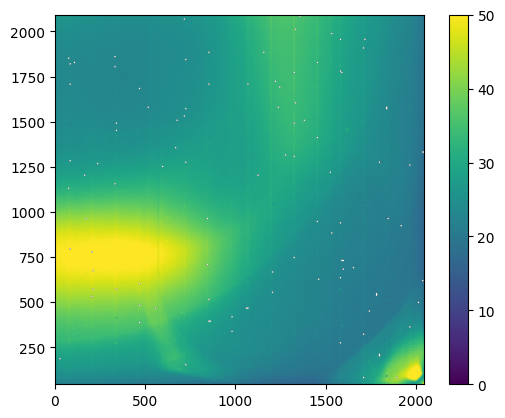

In [204]:
bar = plt.imshow(cube_sl[tdx], origin="lower", vmin=0, vmax=50, extent=(rmin, rmax, cmin, cmax))
plt.colorbar(bar)
plt.show()

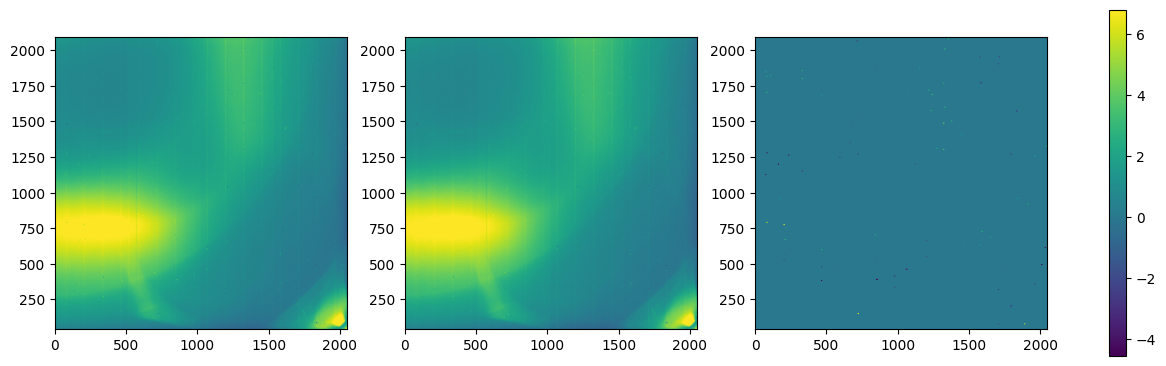

In [205]:
if fillnan:
    fig, ax = plt.subplots(1, 3, figsize=(16,9))
    bar = ax[0].imshow(cube_sl_lin[tdx], origin="lower", vmin=0, vmax=50, extent=(rmin, rmax, cmin, cmax))
    bar = ax[1].imshow(cube_sl_fillcub, origin="lower", vmin=0, vmax=50, extent=(rmin, rmax, cmin, cmax))
    bar = ax[2].imshow(cube_sl_fillcub - cube_sl_lin[tdx], origin="lower", extent=(rmin, rmax, cmin, cmax))
    plt.colorbar(bar, ax=ax, location="right", shrink=.5)
    plt.show()

In [206]:
step = binsize
row, col = np.mgrid[rmin:rmax:step, cmin:cmax:step]
row

array([[   0,    0,    0, ...,    0,    0,    0],
       [   8,    8,    8, ...,    8,    8,    8],
       [  16,   16,   16, ...,   16,   16,   16],
       ...,
       [2024, 2024, 2024, ..., 2024, 2024, 2024],
       [2032, 2032, 2032, ..., 2032, 2032, 2032],
       [2040, 2040, 2040, ..., 2040, 2040, 2040]])

In [207]:
# %%timeit
tdx = 1172
interp2d = RectBivariateSpline(col[0, :], row[:, 0], cube_sl_lin[tdx] if fillnan else cube_sl[tdx])

eval_row = np.arange(rmin, rmax)
eval_col = np.arange(cmin, cmax)

eval_sl = interp2d(eval_col, eval_row)
eval_sl

array([[21.83055878, 21.82467468, 21.81770072, ..., 46.48493195,
        46.48493195, 46.48493195],
       [21.99216474, 22.0021498 , 22.00349905, ..., 45.89949146,
        45.89949146, 45.89949146],
       [22.1381997 , 22.16099227, 22.16931252, ..., 45.27422156,
        45.27422156, 45.27422156],
       ...,
       [27.41618347, 27.40198995, 27.38046748, ..., 19.69589996,
        19.69589996, 19.69589996],
       [27.41618347, 27.40198995, 27.38046748, ..., 19.69589996,
        19.69589996, 19.69589996],
       [27.41618347, 27.40198995, 27.38046748, ..., 19.69589996,
        19.69589996, 19.69589996]])

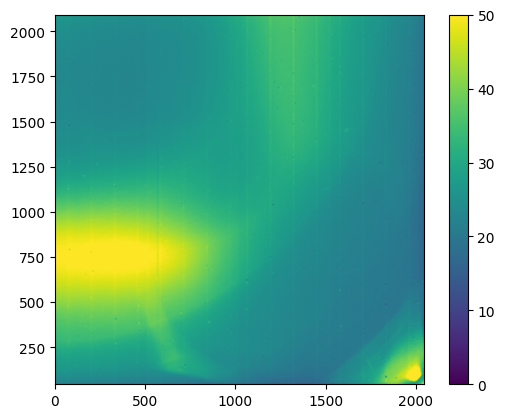

In [208]:
bar = plt.imshow(eval_sl, origin="lower", vmin=0, vmax=50, 
           extent=(eval_row.min(), eval_row.max(), eval_col.min(), eval_col.max()))
plt.colorbar(bar)
plt.show()

## Inspect Resdiuals after upscaling

In [176]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

In [177]:
bkgcube = BackgroundCube(
    sector=sector, camera=camera, ccd=ccd, img_bin=16, downsize="binning"
)
print(bkgcube)

TESS FFI Background object (Sector, Camera, CCD, N times): 2, 2, 4, 1245


In [178]:
bkgcube._get_dark_frame_idx()
bkgcube._get_star_mask(sigma=5.0, dilat_iter=2)
bkgcube._get_straps_mask()
static = bkgcube._get_static_scene()

Computing average static scene from darkes frames...


100%|██████████| 125/125 [03:41<00:00,  1.77s/it]


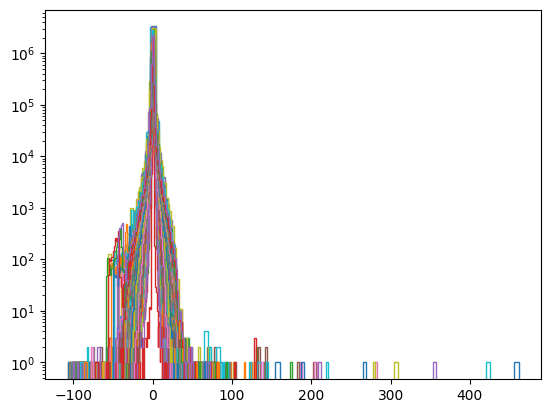

In [179]:
metrics = pd.DataFrame(columns=["mean", "std", "median", "mad", "rchi2", "skew", "kurtosis"])

step = binsize
row = np.arange(rmin, rmax, step)
col = np.arange(cmin, cmax, step)
eval_row = np.arange(rmin, rmax)
eval_col = np.arange(cmin, cmax)

bkgcube.bkg_pixels = ~bkgcube.star_mask
bkgcube.bkg_pixels &= ~bkgcube.strap_mask
mask_pixels = ~bkgcube.bkg_pixels

for tdx in tqdm(range(0, cube_sl_lin.shape[0], 10)):

    interp2d = RectBivariateSpline(col, row, cube_sl_lin[tdx] if fillnan else cube_sl[tdx])
    eval_sl = interp2d(eval_col, eval_row)
    
    raw = bkgcube.tcube.get_ffi(tdx)[1].data[
        bkgcube.rmin : bkgcube.rmax, bkgcube.cmin : bkgcube.cmax
    ]
    raw[mask_pixels] = np.nan
    current = raw - static

    metrics.loc[tdx, "mean"] = np.nanmean((current - eval_sl).ravel())
    metrics.loc[tdx, "std"] = np.nanstd((current - eval_sl).ravel())
    metrics.loc[tdx, "median"] = np.nanmedian((current - eval_sl).ravel())
    metrics.loc[tdx, "mad"] = stats.median_abs_deviation((current - eval_sl).ravel(), center=np.nanmedian, nan_policy="omit")

    zero_mask = current != 0
    metrics.loc[tdx, "rchi2"] = np.nansum((eval_sl[zero_mask] - current[zero_mask])** 2 / np.sqrt(current[zero_mask])) / np.multiply(*current.shape)
    metrics.loc[tdx, "skew"] = stats.skew((current - eval_sl).ravel(), nan_policy="omit")
    metrics.loc[tdx, "kurtosis"] = stats.kurtosis((current - eval_sl).ravel(), nan_policy="omit")

    plt.hist((current - eval_sl).ravel(), bins=100, log=True, histtype="step", lw=10)

    # break
plt.show()

In [180]:
metrics.to_csv(f"./data/residual_metrics_sl_bin{binsize}_sector{sector:03}_{camera}-{ccd}.csv")

In [182]:
metrics8 = pd.read_csv(f"./data/residual_metrics_sl_bin8_sector{sector:03}_{camera}-{ccd}.csv")
metrics16 = pd.read_csv(f"./data/residual_metrics_sl_bin16_sector{sector:03}_{camera}-{ccd}.csv")

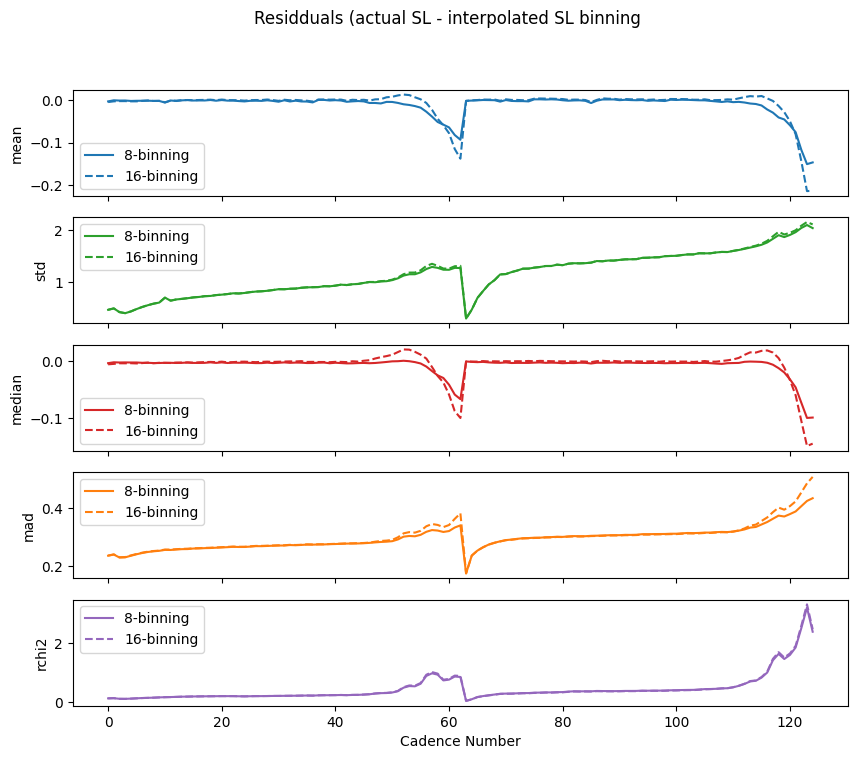

In [196]:
cols = ["mean", "std", "median", "mad", "rchi2"]
colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:purple"]
fig, ax = plt.subplots(len(cols), 1, figsize=(len(cols)*2, 8), sharex=True)
for k, c in enumerate(cols):
    ax[k].plot(metrics8[c], c=colors[k], ls="-", label="8-binning")
    ax[k].plot(metrics16[c], c=colors[k], ls="--", label="16-binning")
    ax[k].set_ylabel(c)
    ax[k].legend()

ax[-1].set_xlabel("Cadence Number")
fig.suptitle(f"Residduals (actual SL - interpolated SL binning")
plt.show()

## Correct Scatter Light in FFI light curves

TOIs in this Sector/Camera/CCD

| TIC       | Camera | CCD | TOI Disposition | RA | Dec | TMag |
|-----------|--------|-----|-----------------|----|-----|------|
| 144440290 | 2 | 4 |	EB | 359.161519 | -44.719088 | 8.723  |
| 183537452 | 2 | 4 |	KP | 357.879533 | -39.906726 | 10.195 |
| 183985250 | 2 | 4 |	CP | 358.667547 | -37.628020 | 9.098  |
| 184240683 | 2 | 4 |	KP | 359.348992 | -41.277150 | 11.502 |
| 224225541 | 2 | 4 |	CP | 353.061818 | -37.255890 | 9.307  |
| 402026209 | 2 | 4 |	KP | 353.562839 | -42.061409 | 11.778 |


In [227]:
from tesscube import TESSCube
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from scipy import ndimage
from glob import glob
import os

In [210]:
tois = pd.DataFrame(
    [
        [144440290, 2, 4, "EB", 359.161519, -44.719088, 8.723],
        [183537452, 2, 4, "KP", 357.879533, -39.906726, 10.195],
        [183985250, 2, 4, "CP", 358.667547, -37.628020, 9.098],
        [184240683, 2, 4, "KP", 359.348992, -41.277150, 11.502],
        [224225541, 2, 4, "CP", 353.061818, -37.255890, 9.307],
        [402026209, 2, 4, "KP", 353.562839, -42.061409, 11.778,]
    ],
    columns=["TIC", "camera", "ccd", "disposition","ra", "dec","tmag"]
)
tois

TIC  camera  ccd disposition          ra        dec    tmag
0  144440290       2    4          EB  359.161519 -44.719088   8.723
1  183537452       2    4          KP  357.879533 -39.906726  10.195
2  183985250       2    4          CP  358.667547 -37.628020   9.098
3  184240683       2    4          KP  359.348992 -41.277150  11.502
4  224225541       2    4          CP  353.061818 -37.255890   9.307
5  402026209       2    4          KP  353.562839 -42.061409  11.778

In [211]:
tics = pd.read_csv(f"./data/all_targets_S{sector:03}_v1.csv", skiprows=5).query(f"Camera == {camera} and CCD == {ccd}")
tics = tics.rename(columns={"TICID":"TIC", "RA": "ra", "Dec": "dec"})
tics

TIC  Camera  CCD   Tmag        ra      dec
126      7129031       2    4   9.86    3.9531 -44.1077
127      7129680       2    4  10.51    4.1044 -43.3082
128      7129726       2    4   9.08    4.2241 -43.5406
129      7129788       2    4   8.66    4.1466 -43.8581
134      7144448       2    4   8.19    4.3010 -44.3644
...          ...     ...  ...    ...       ...      ...
15575  425864422       2    4   8.16  352.1221 -44.5869
15576  425864448       2    4   8.12  352.0632 -44.4626
15577  425864469       2    4  10.63  352.0835 -44.3856
15920  469914888       2    4   9.87  350.4189 -49.0417
15979  471013556       2    4  15.81  358.0342 -36.1778

[770 rows x 6 columns]

In [225]:
flist = sorted(glob(f"./data/tic_*_sector{sector}_{camera}-{ccd}.fits"))
plot_ids = np.array([int(float(x.split("_")[1])) for x in flist])
tics_plot = tics[np.isin(tics.TIC.values, plot_ids)].sort_values("TIC")

In [316]:
tcube = TESSCube(sector=sector, camera=camera, ccd=ccd)

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


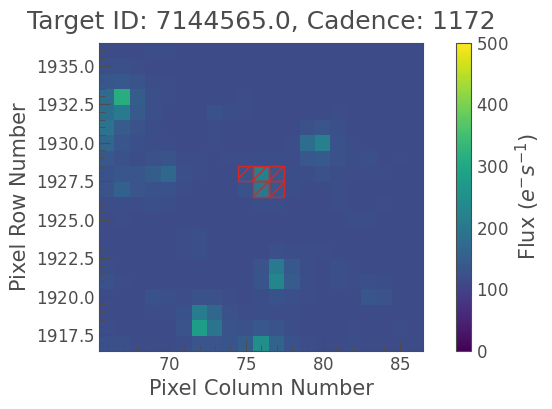

100%|██████████| 1245/1245 [00:04<00:00, 281.90it/s]


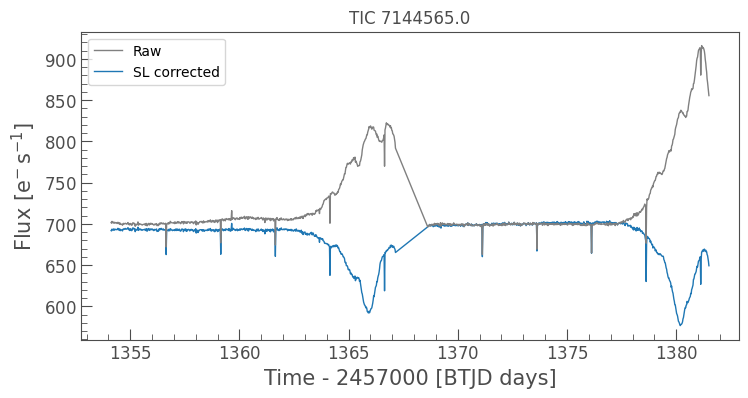

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


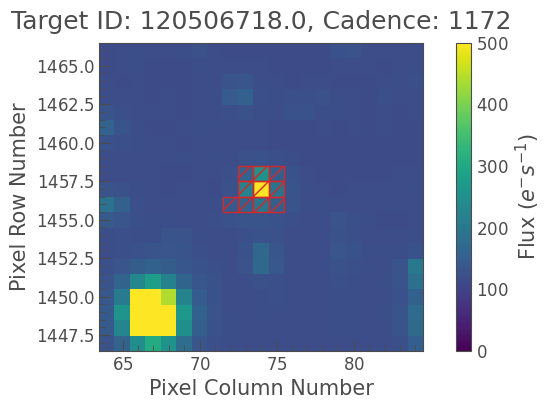

100%|██████████| 1245/1245 [00:04<00:00, 284.42it/s]


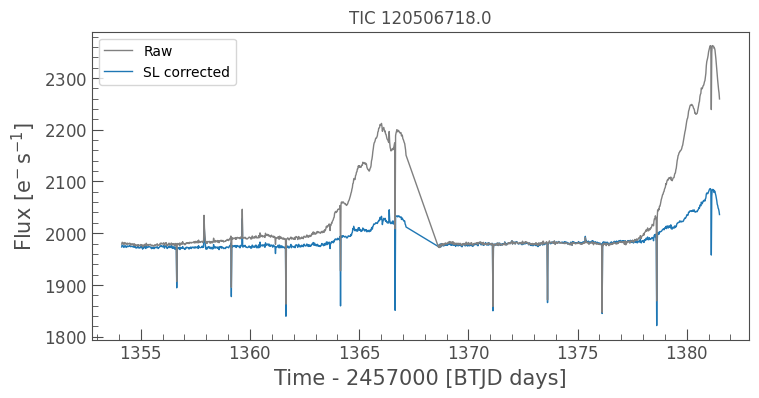

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


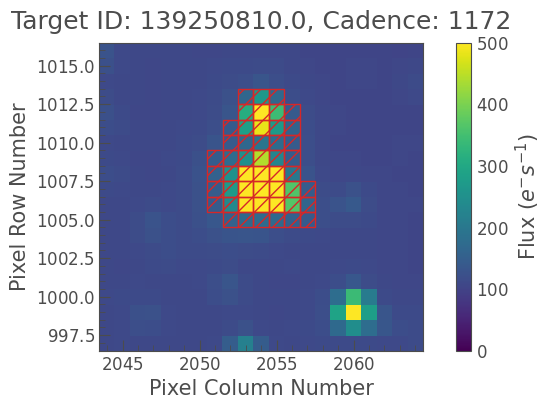

100%|██████████| 1245/1245 [00:04<00:00, 282.33it/s]


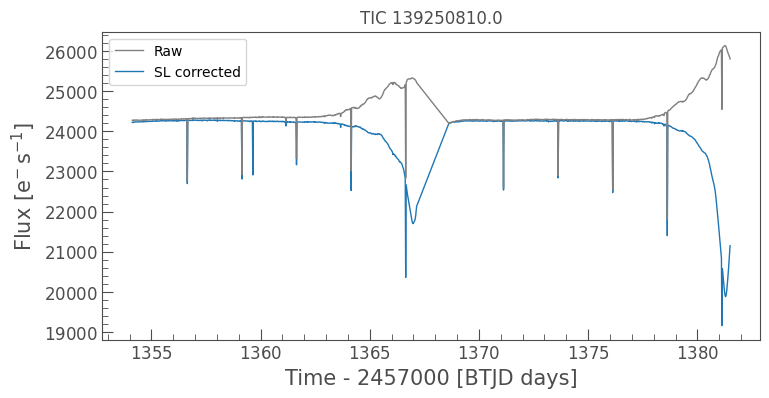

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


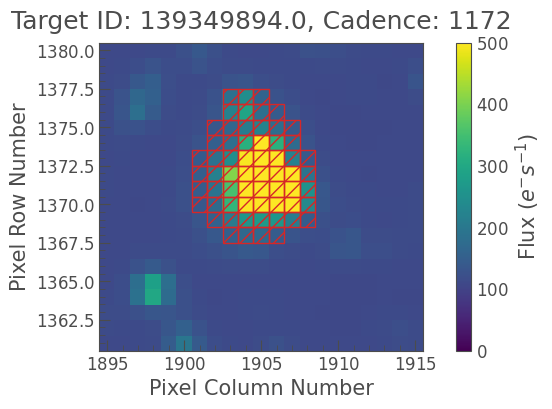

100%|██████████| 1245/1245 [00:04<00:00, 283.45it/s]


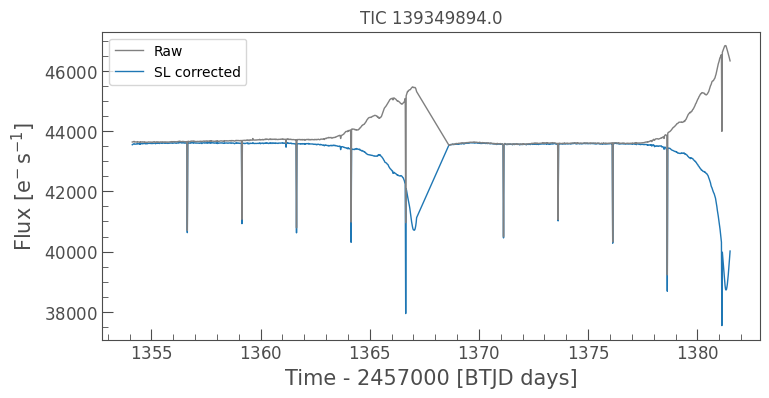

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


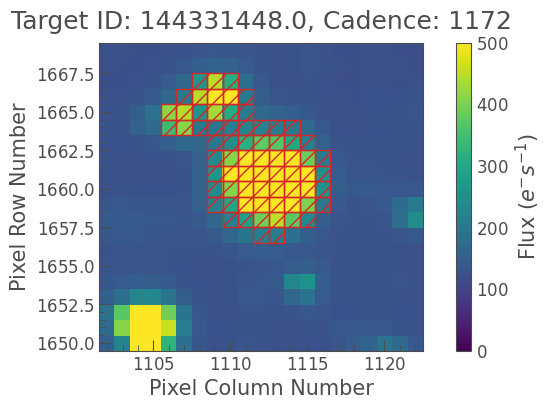

100%|██████████| 1245/1245 [00:04<00:00, 281.68it/s]


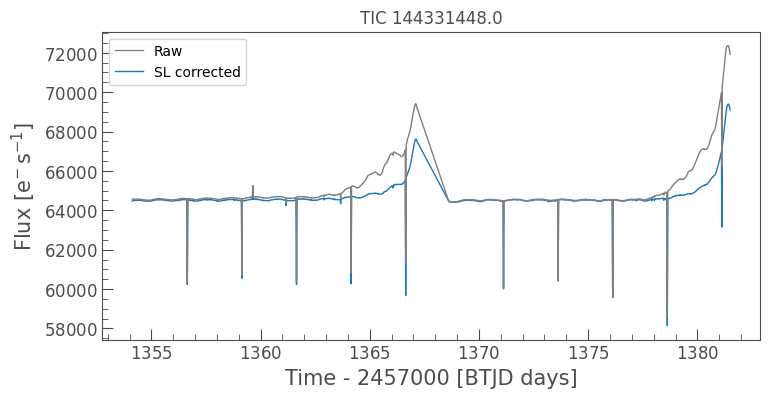

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


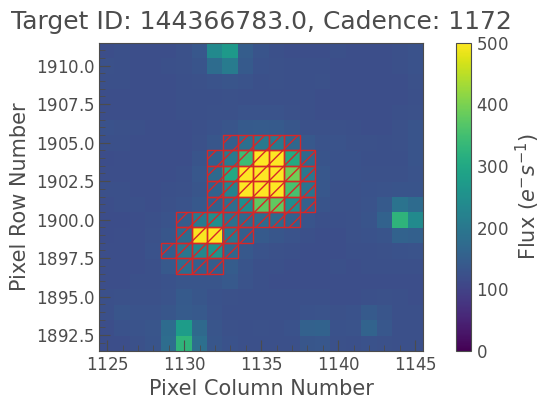

100%|██████████| 1245/1245 [00:04<00:00, 283.90it/s]


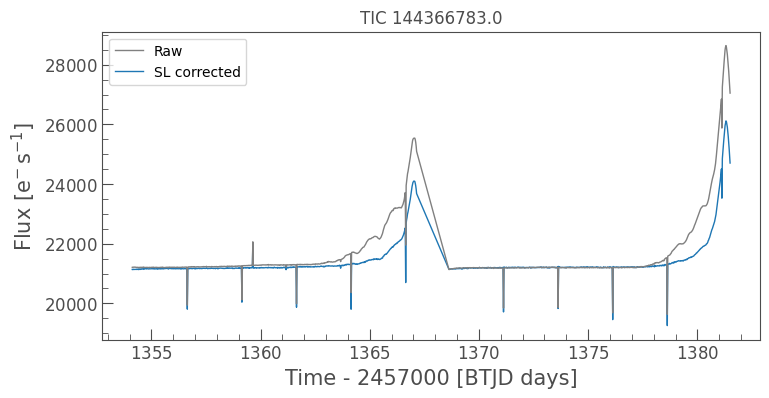

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


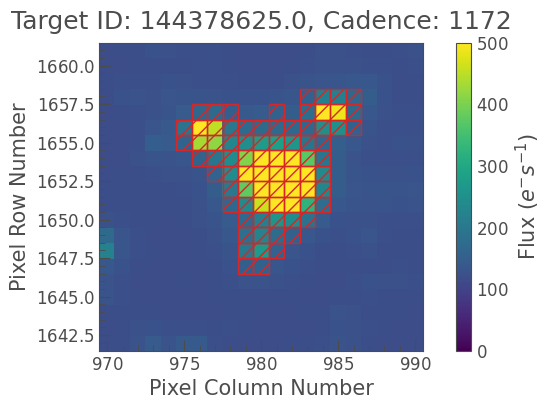

100%|██████████| 1245/1245 [00:04<00:00, 282.70it/s]


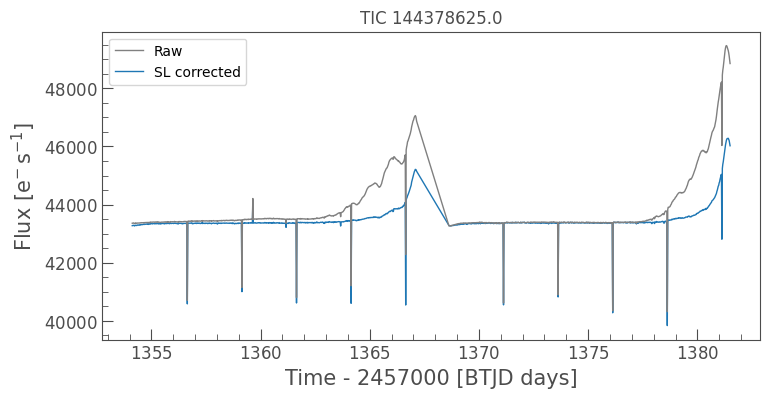

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


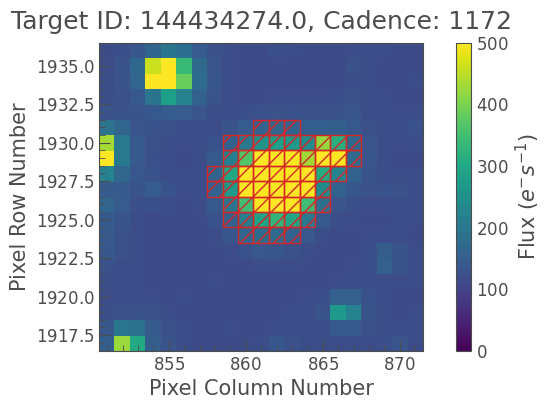

100%|██████████| 1245/1245 [00:04<00:00, 285.74it/s]


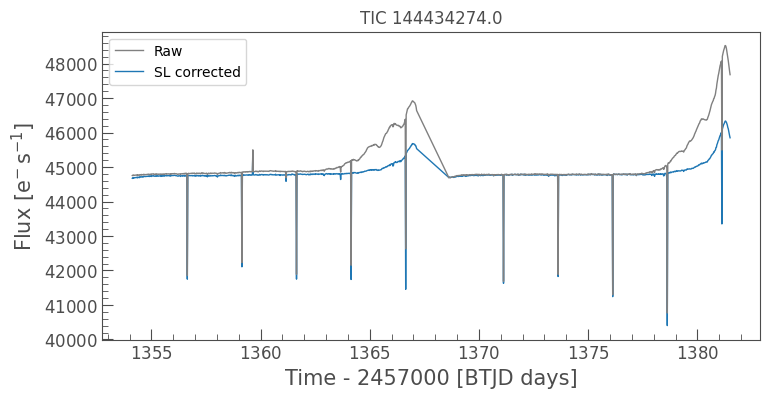

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


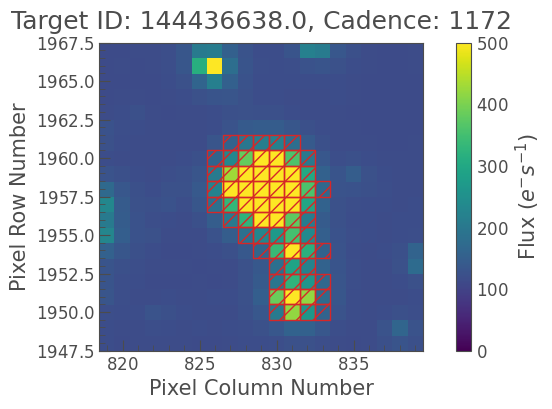

100%|██████████| 1245/1245 [00:04<00:00, 280.83it/s]


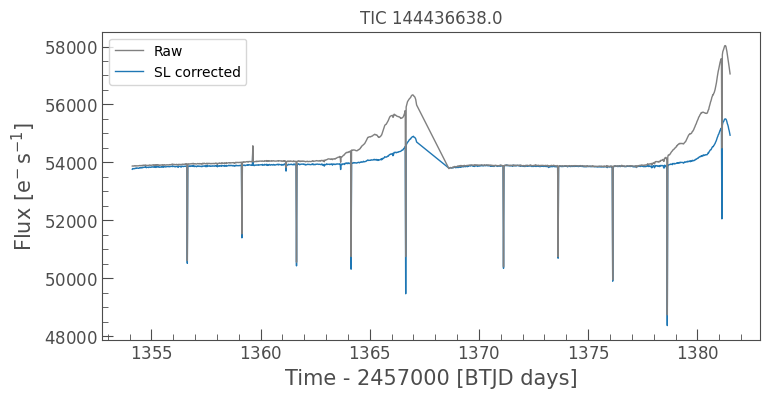

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


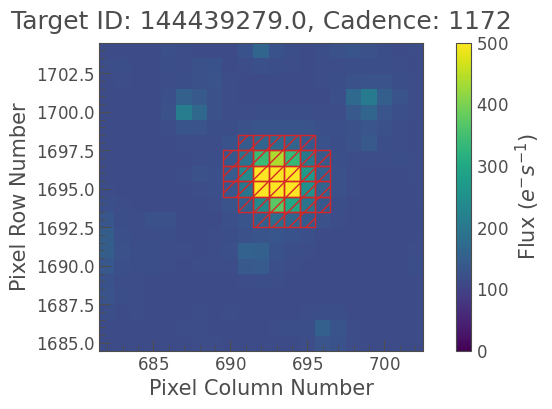

100%|██████████| 1245/1245 [00:04<00:00, 283.27it/s]


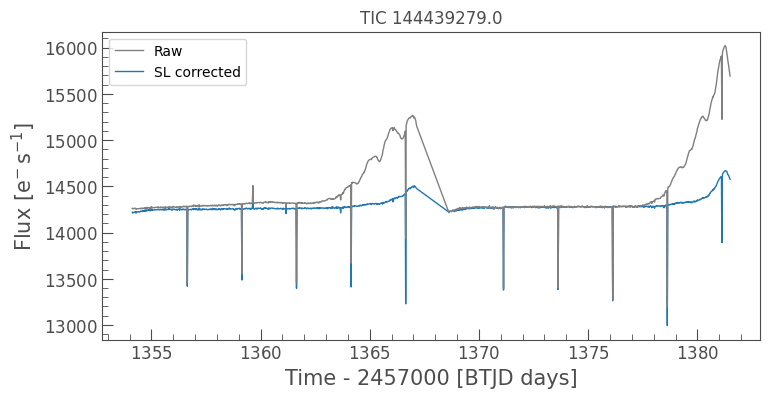

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


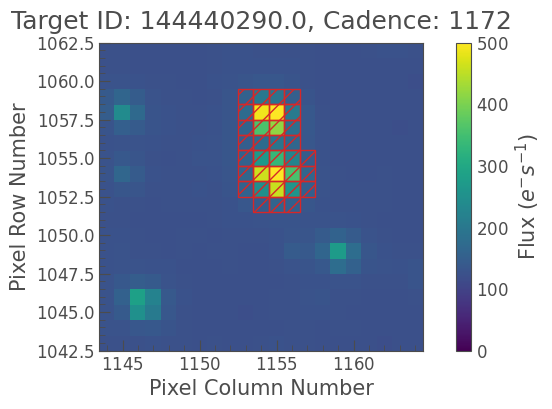

100%|██████████| 1245/1245 [00:04<00:00, 282.52it/s]


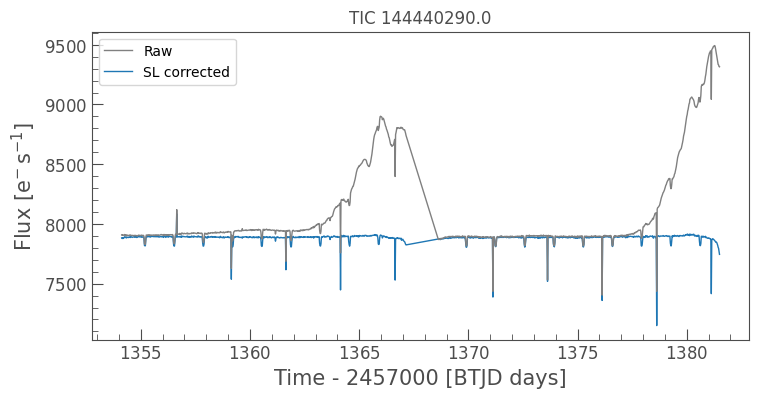

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


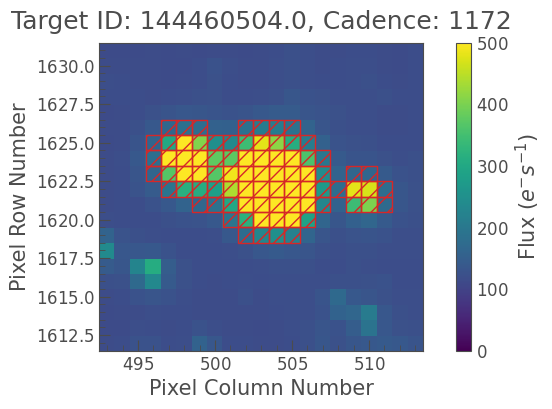

100%|██████████| 1245/1245 [00:04<00:00, 285.23it/s]


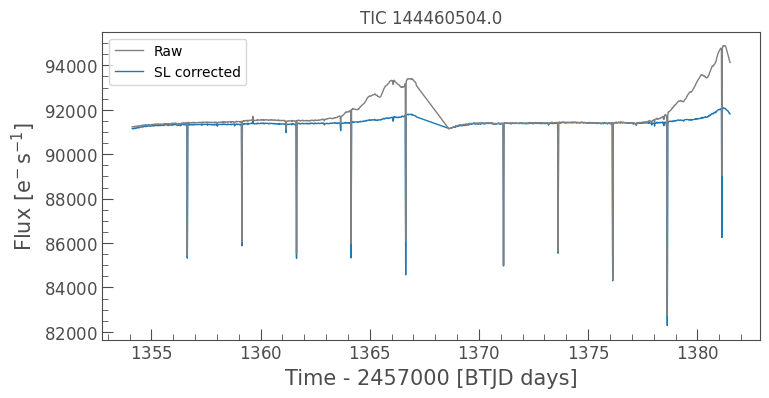

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


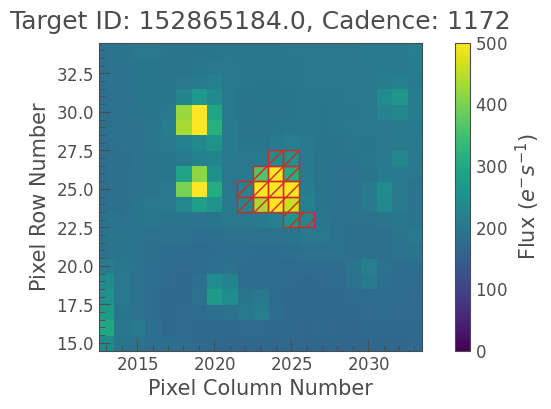

100%|██████████| 1245/1245 [00:04<00:00, 277.14it/s]


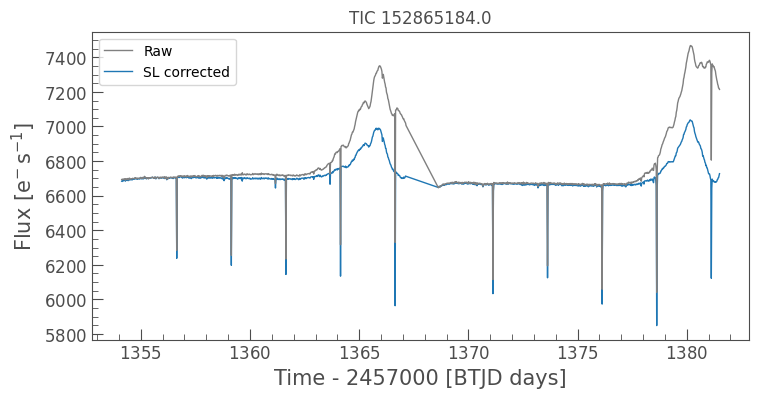

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


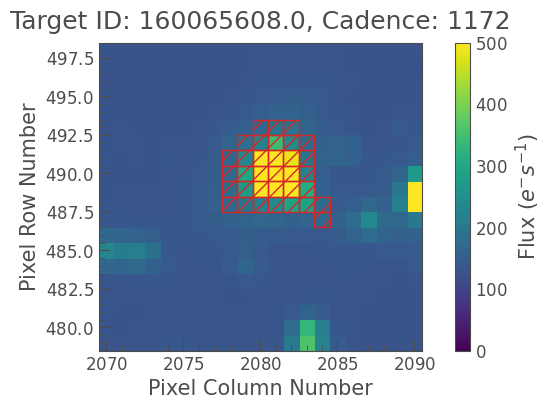

100%|██████████| 1245/1245 [00:04<00:00, 284.22it/s]


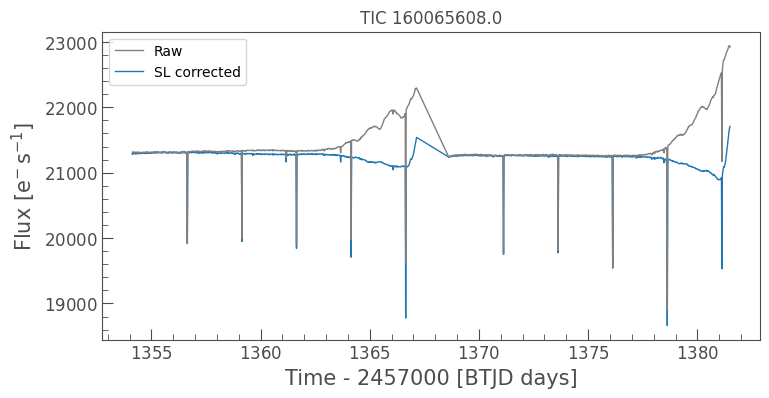

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


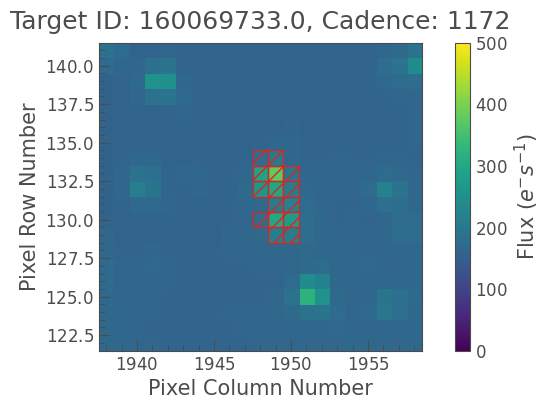

100%|██████████| 1245/1245 [00:04<00:00, 282.38it/s]


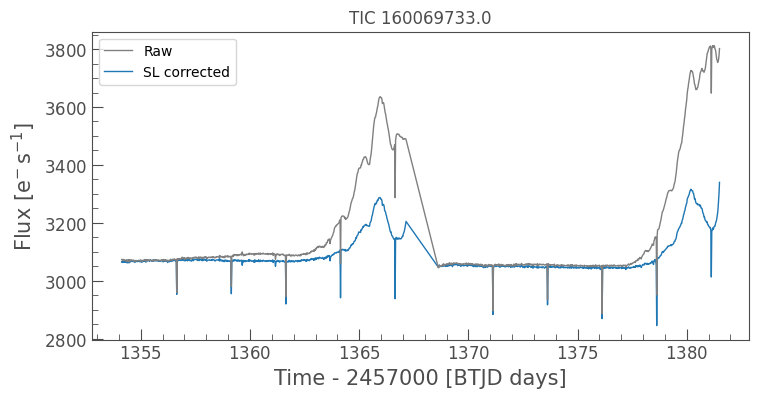

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


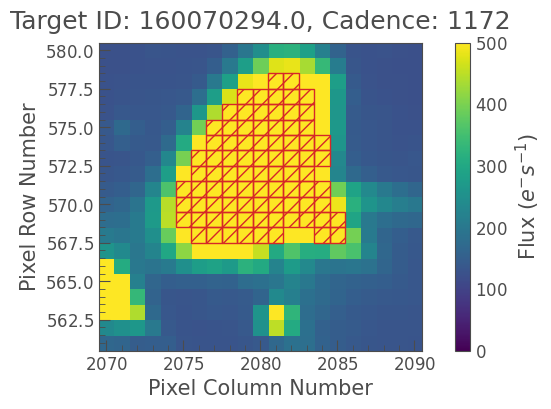

100%|██████████| 1245/1245 [00:04<00:00, 281.24it/s]


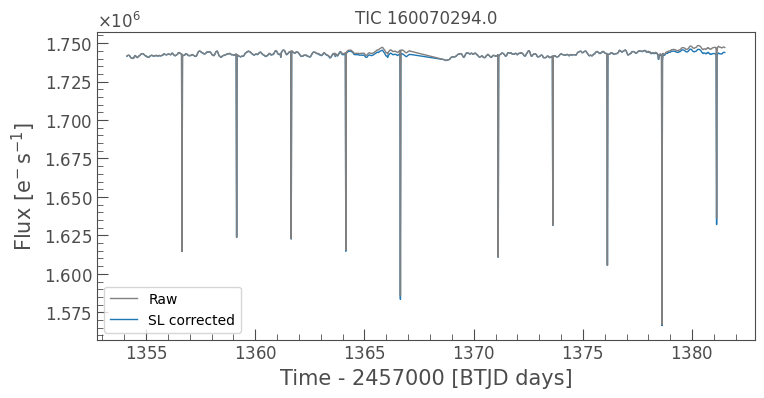

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


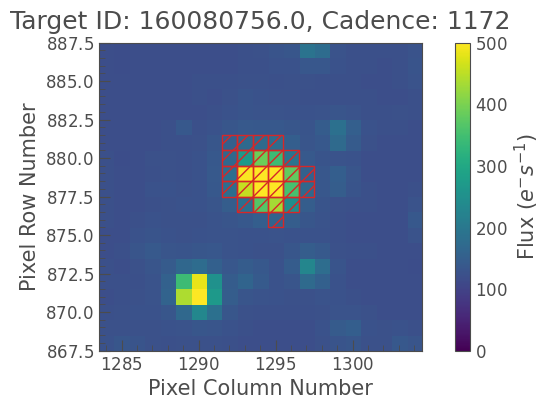

100%|██████████| 1245/1245 [00:04<00:00, 275.37it/s]


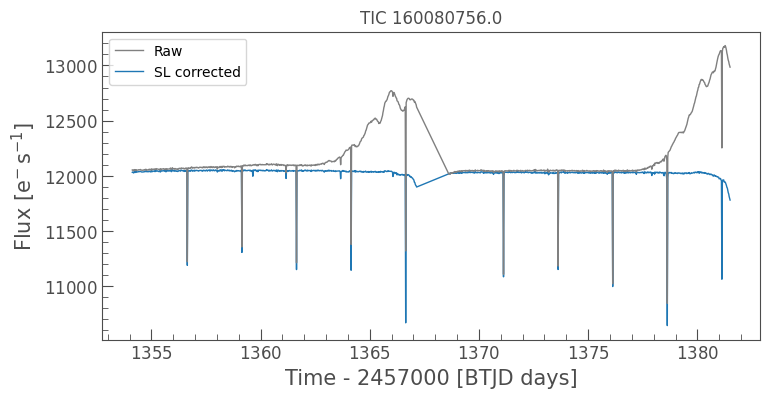

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


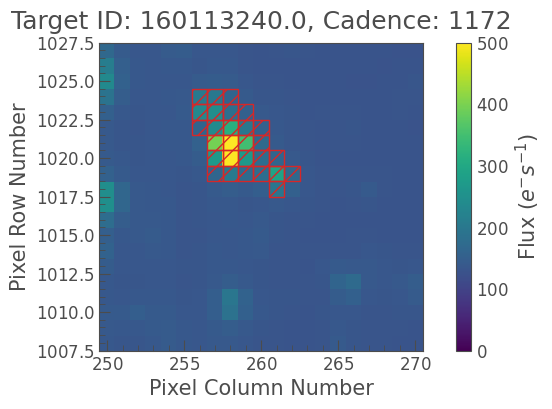

100%|██████████| 1245/1245 [00:04<00:00, 285.09it/s]


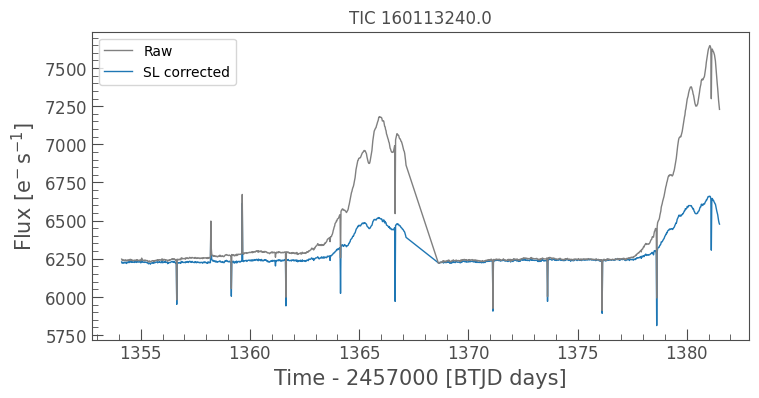

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


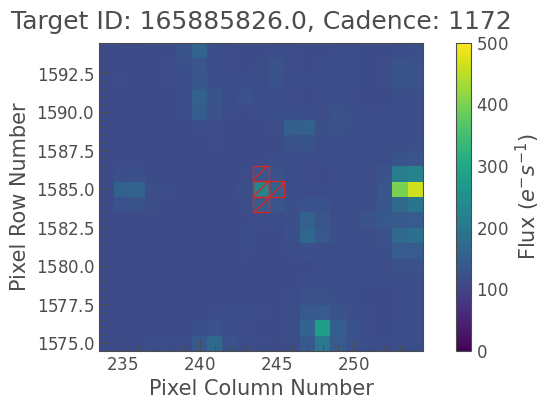

100%|██████████| 1245/1245 [00:04<00:00, 282.96it/s]


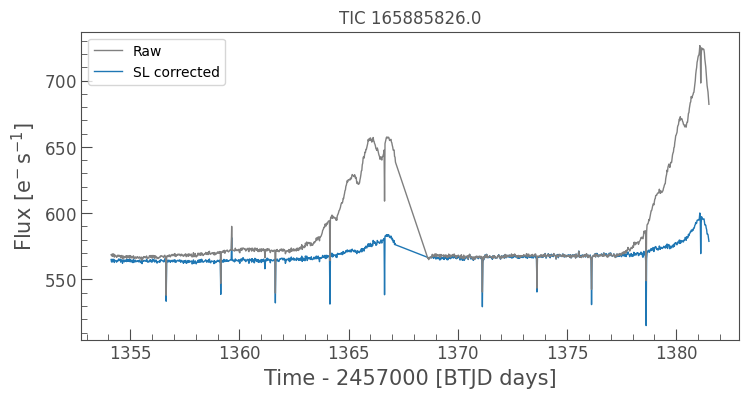

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


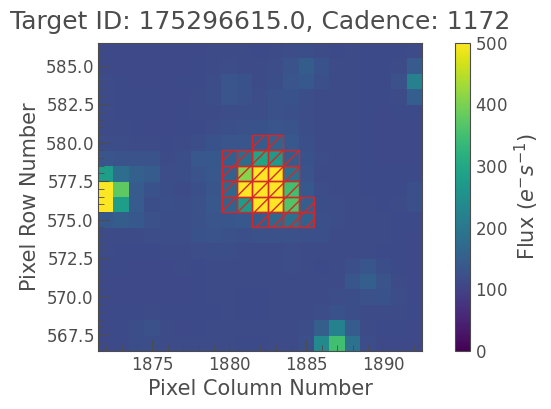

100%|██████████| 1245/1245 [00:04<00:00, 284.45it/s]


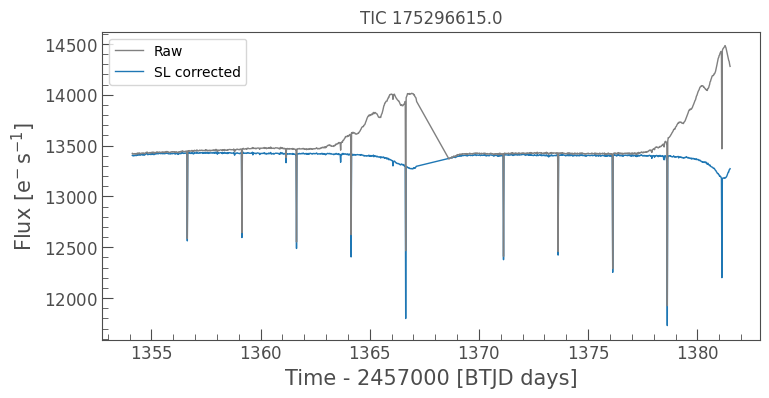

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


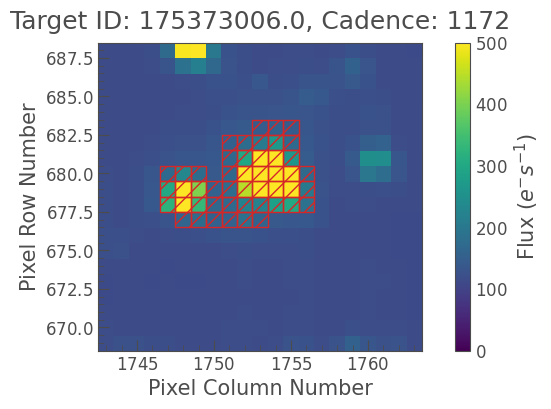

100%|██████████| 1245/1245 [00:04<00:00, 282.99it/s]


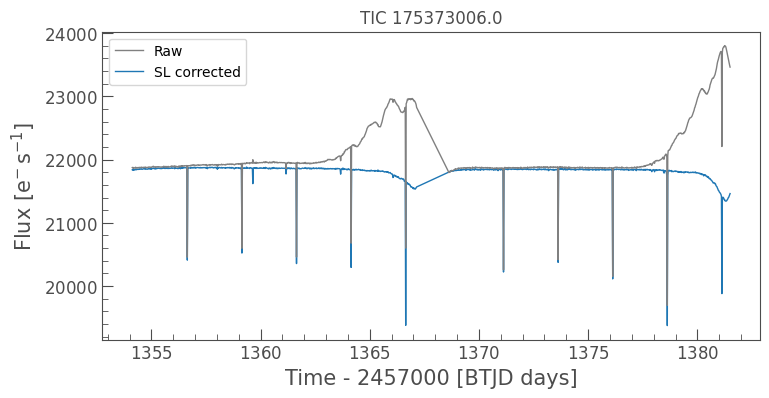

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


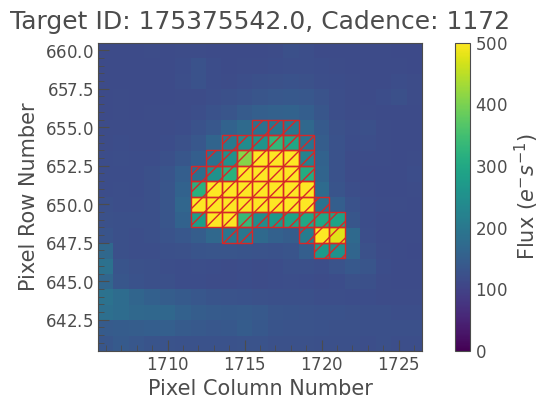

100%|██████████| 1245/1245 [00:04<00:00, 284.08it/s]


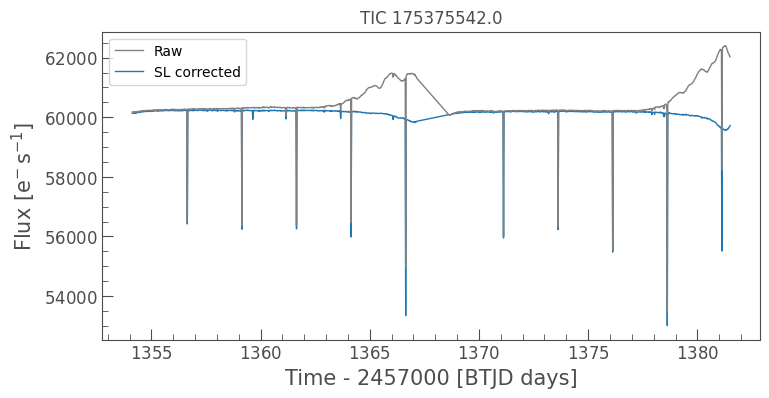

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


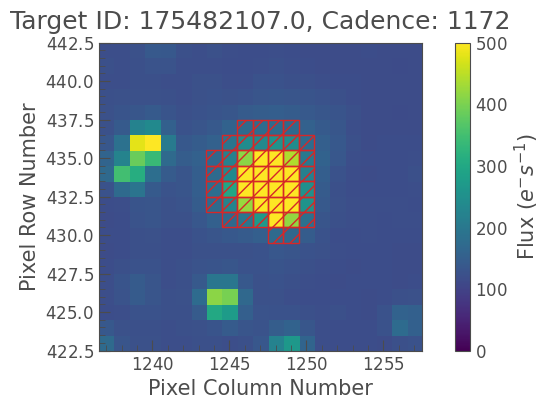

100%|██████████| 1245/1245 [00:04<00:00, 285.49it/s]


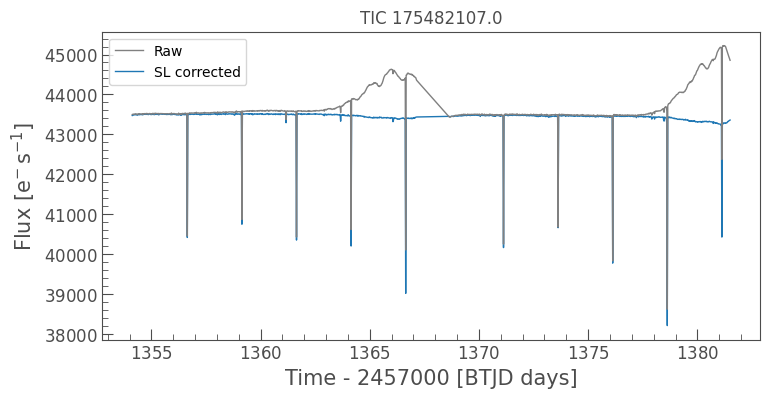

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


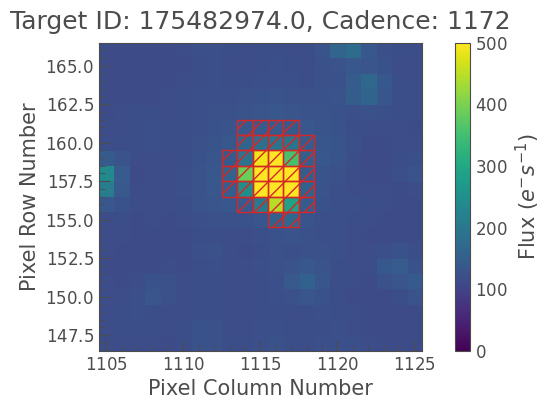

100%|██████████| 1245/1245 [00:04<00:00, 281.99it/s]


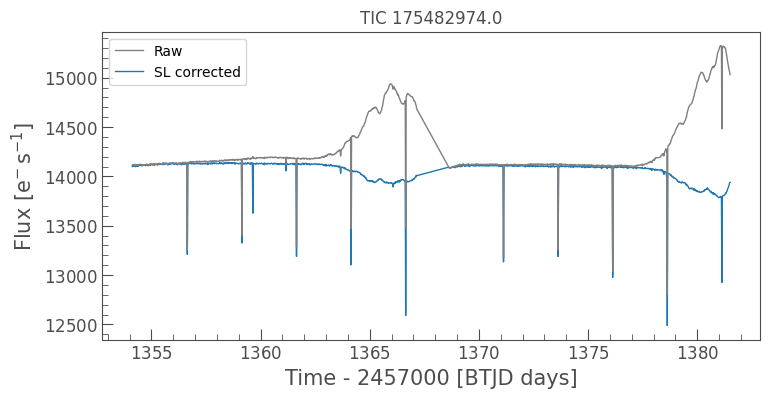

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


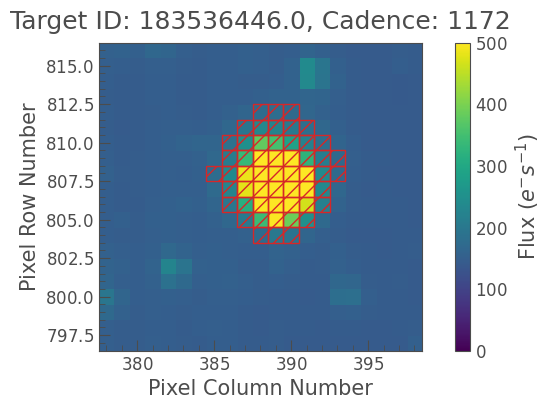

100%|██████████| 1245/1245 [00:04<00:00, 284.82it/s]


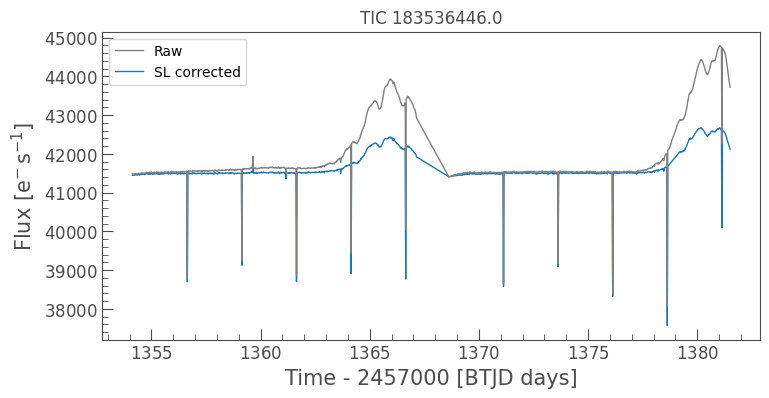

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


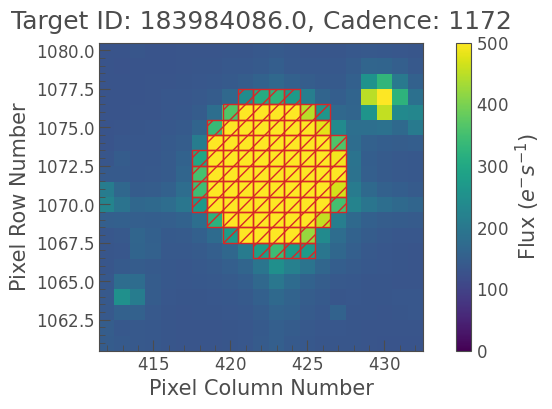

100%|██████████| 1245/1245 [00:04<00:00, 279.86it/s]


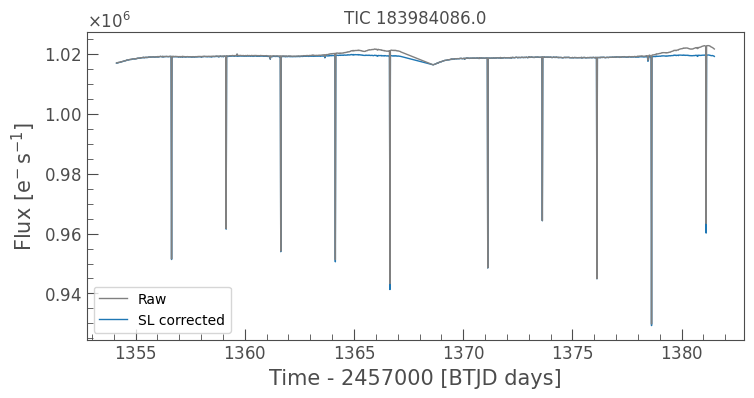

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


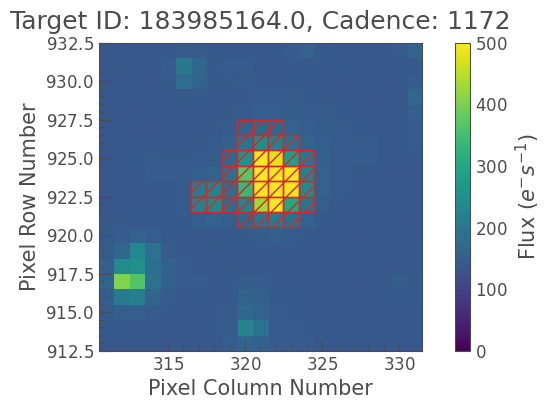

100%|██████████| 1245/1245 [00:04<00:00, 282.91it/s]


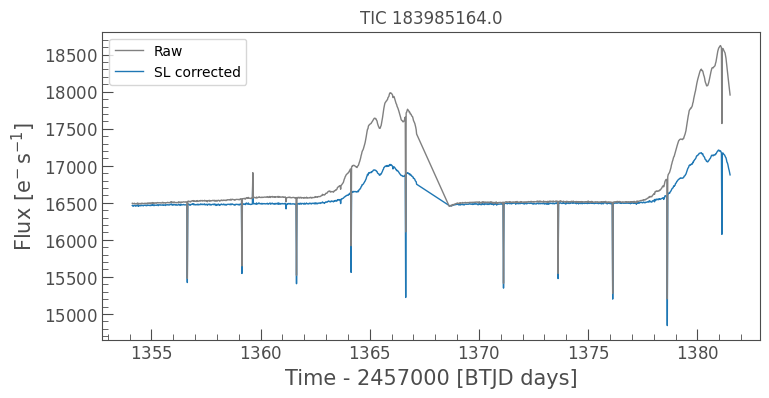

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


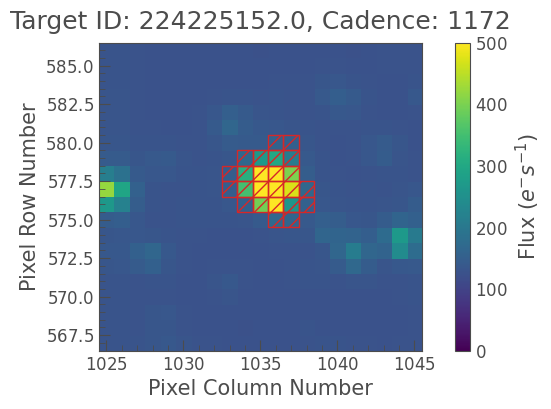

100%|██████████| 1245/1245 [00:04<00:00, 279.78it/s]


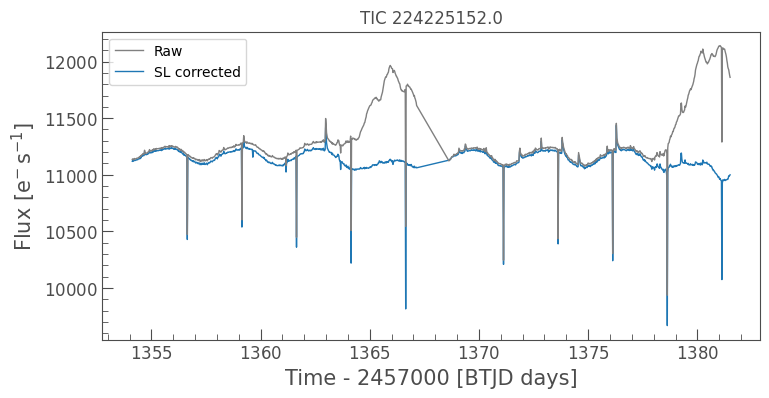

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


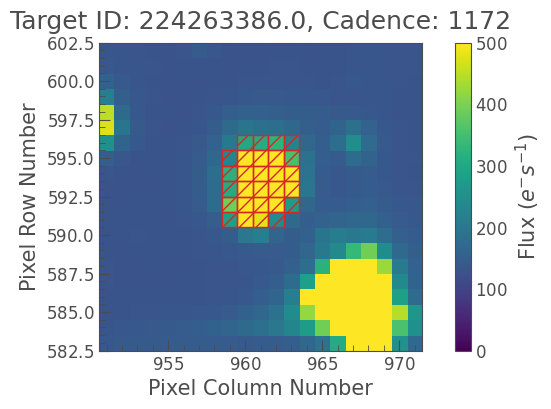

100%|██████████| 1245/1245 [00:04<00:00, 284.63it/s]


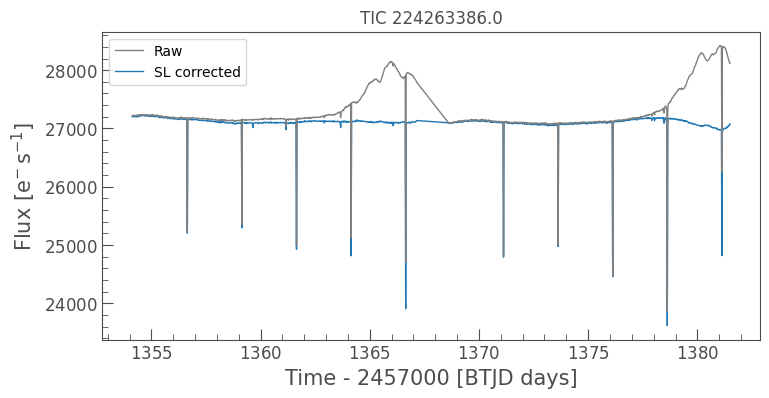

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


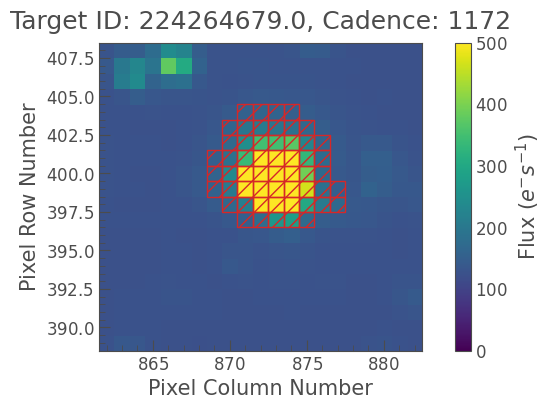

100%|██████████| 1245/1245 [00:04<00:00, 283.00it/s]


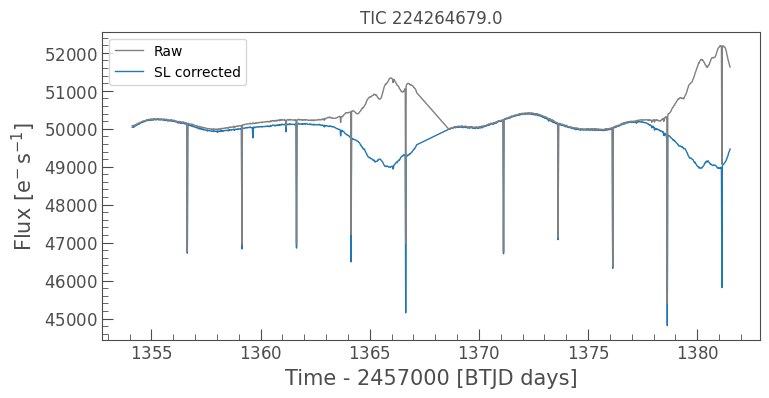

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


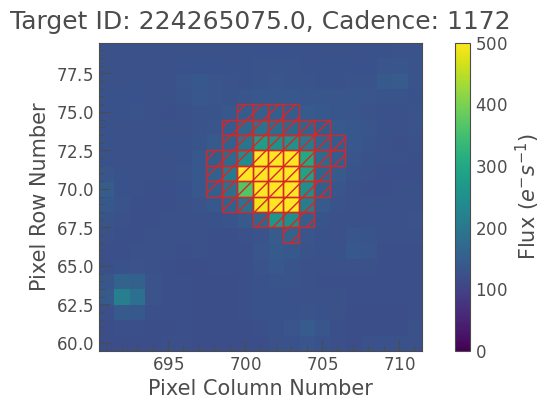

100%|██████████| 1245/1245 [00:04<00:00, 283.65it/s]


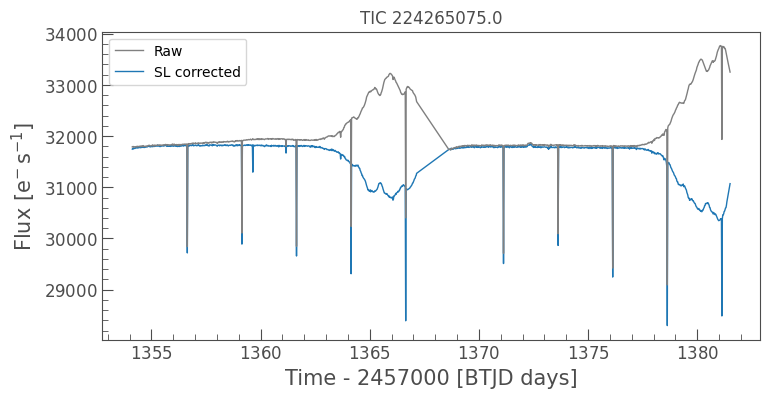

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


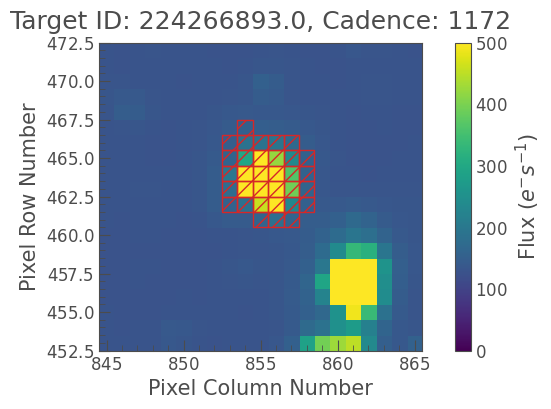

100%|██████████| 1245/1245 [00:04<00:00, 281.58it/s]


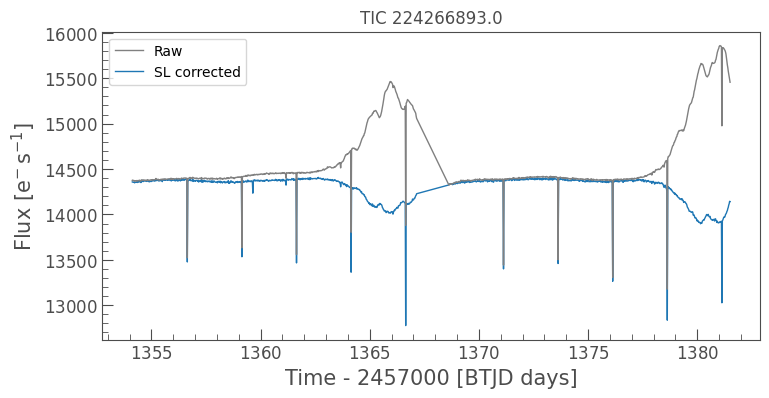

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


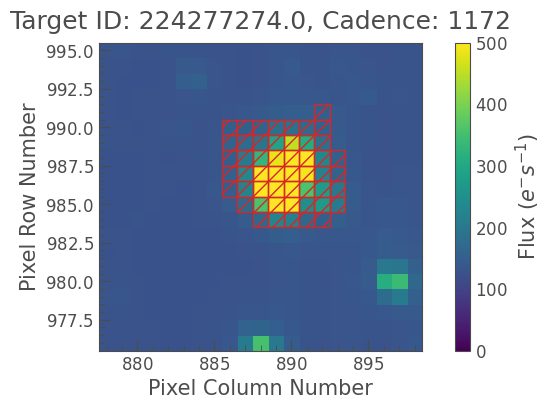

100%|██████████| 1245/1245 [00:04<00:00, 282.53it/s]


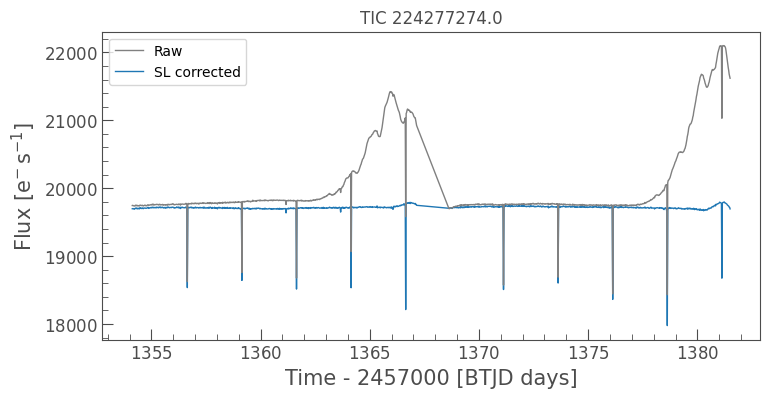

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


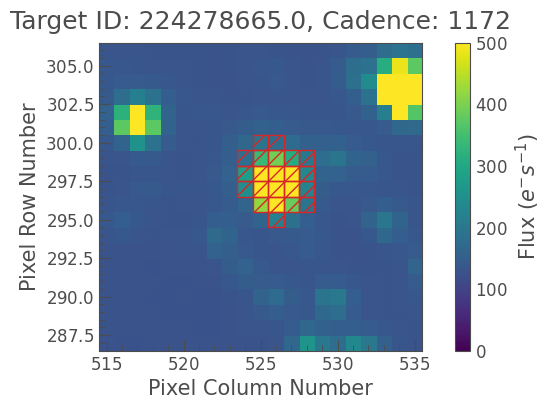

100%|██████████| 1245/1245 [00:04<00:00, 283.13it/s]


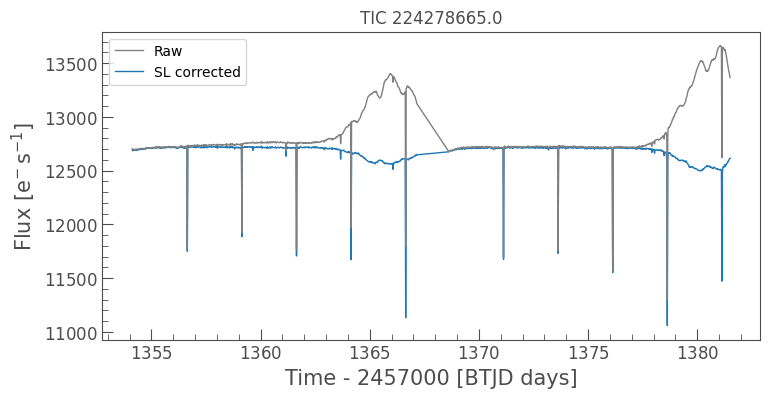

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


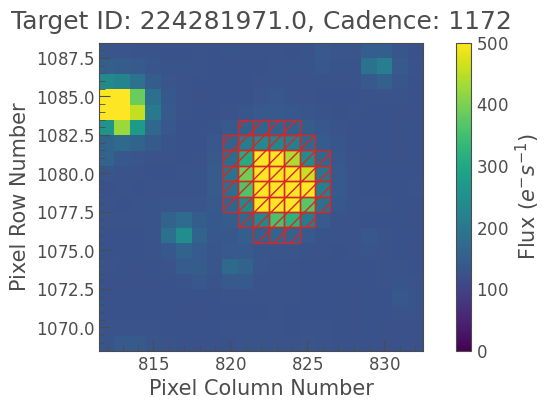

100%|██████████| 1245/1245 [00:04<00:00, 285.72it/s]


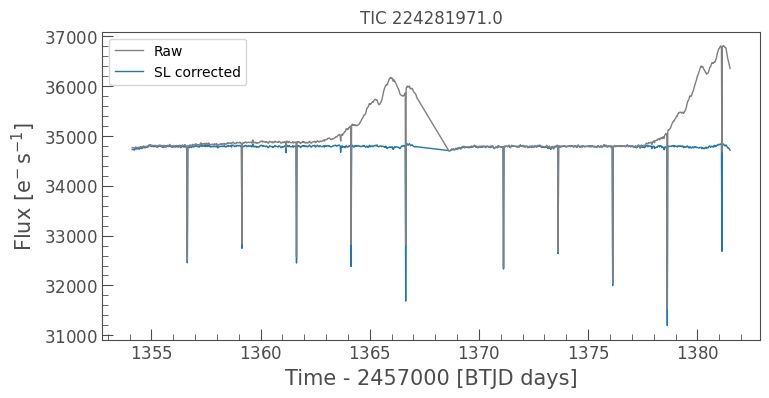

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


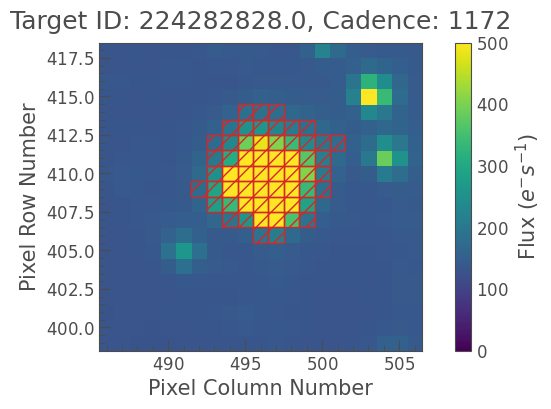

100%|██████████| 1245/1245 [00:04<00:00, 281.38it/s]


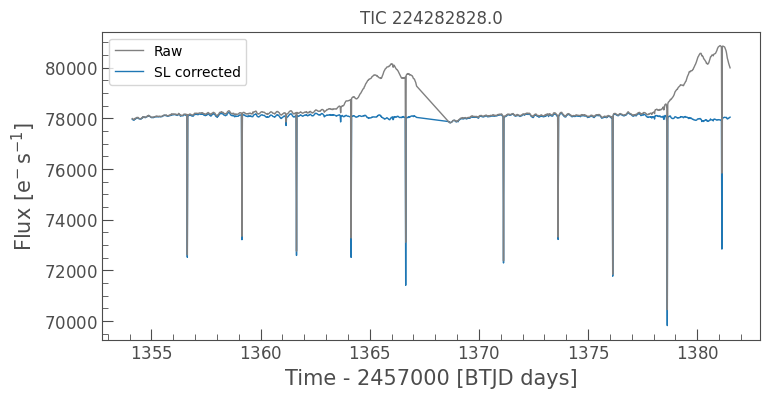

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


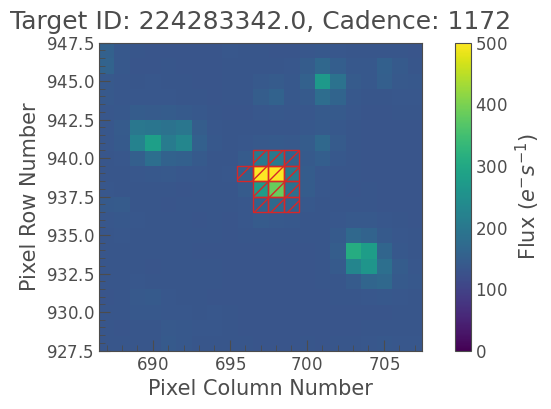

100%|██████████| 1245/1245 [00:04<00:00, 280.81it/s]


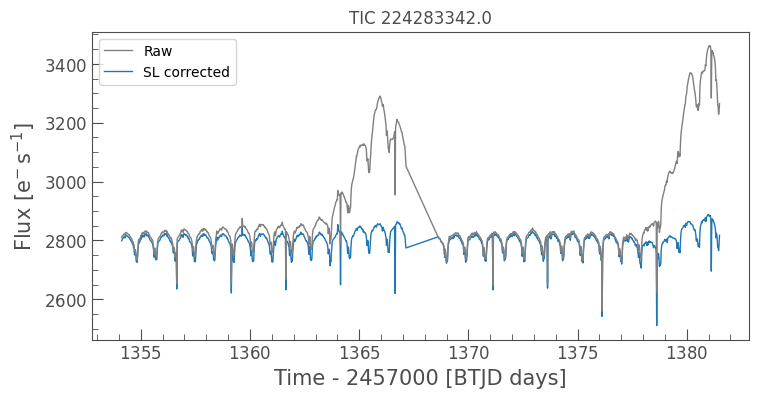

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


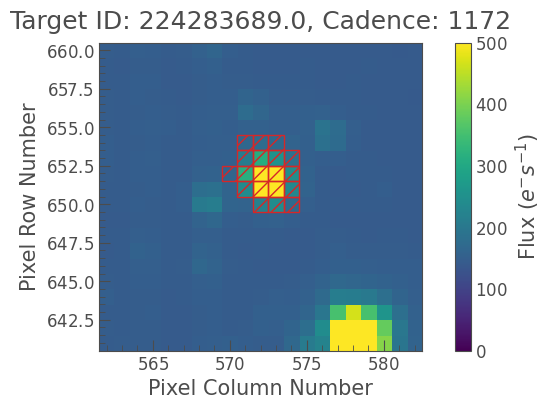

100%|██████████| 1245/1245 [00:04<00:00, 281.67it/s]


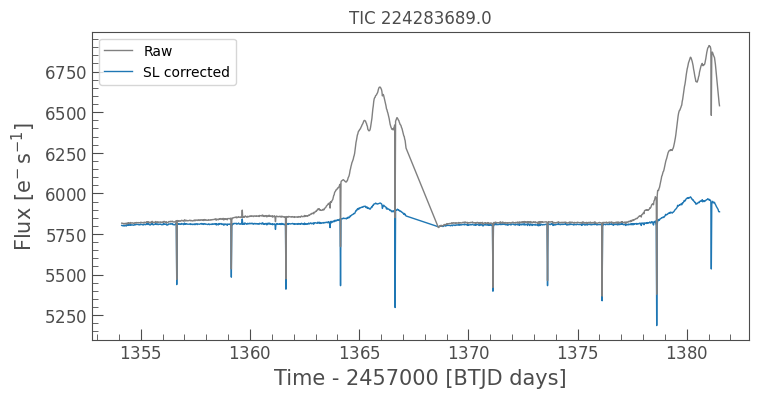

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


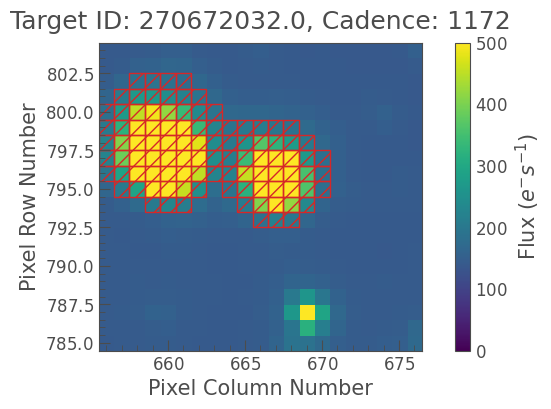

100%|██████████| 1245/1245 [00:04<00:00, 283.66it/s]


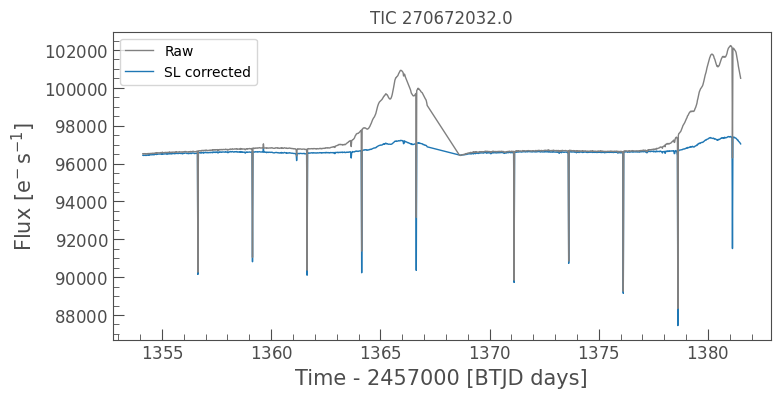

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


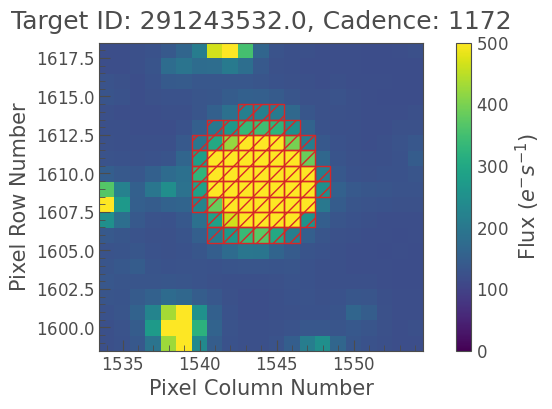

100%|██████████| 1245/1245 [00:04<00:00, 279.67it/s]


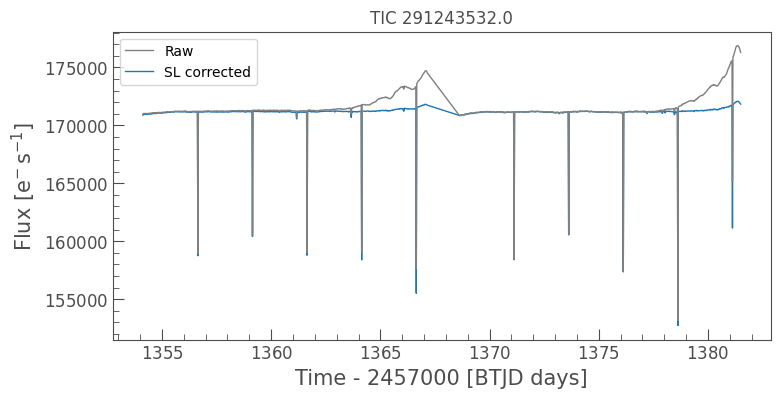

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


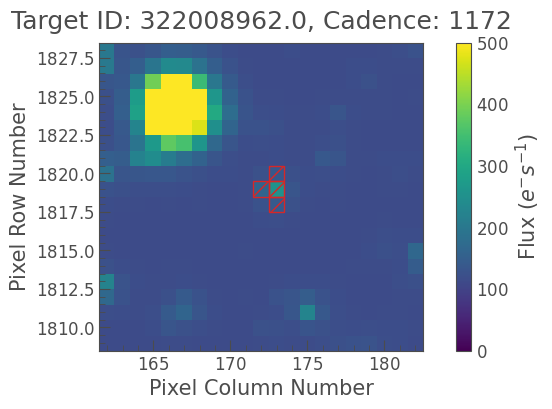

100%|██████████| 1245/1245 [00:04<00:00, 282.71it/s]


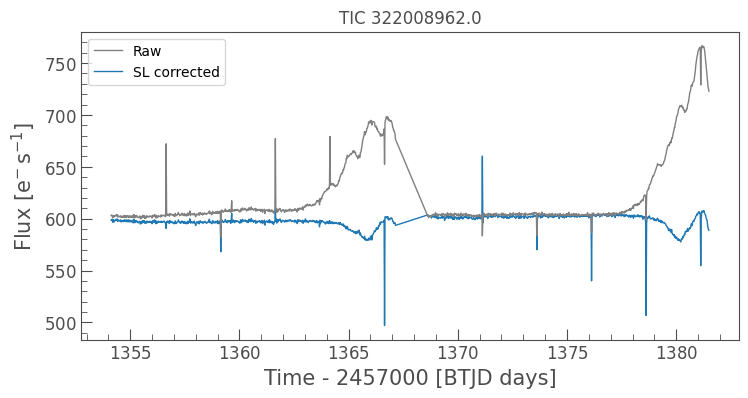

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


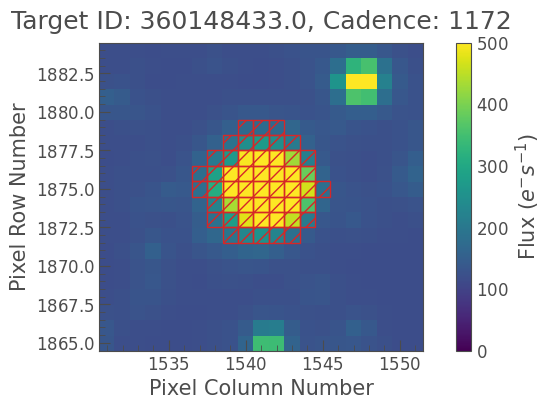

100%|██████████| 1245/1245 [00:04<00:00, 284.36it/s]


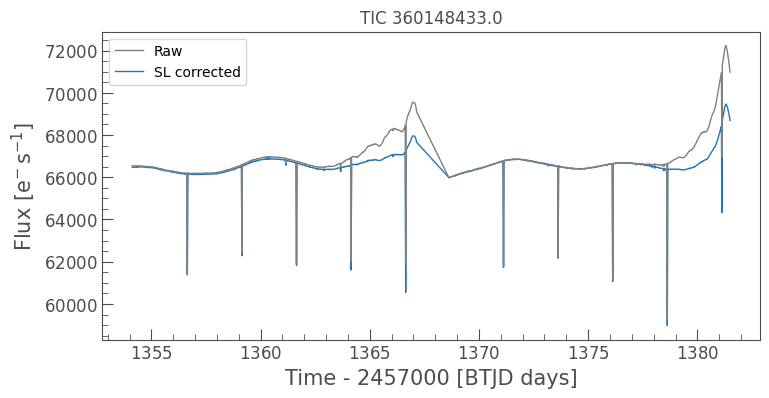

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


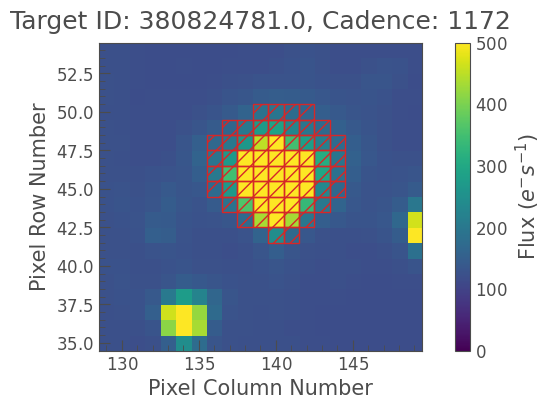

100%|██████████| 1245/1245 [00:04<00:00, 284.94it/s]


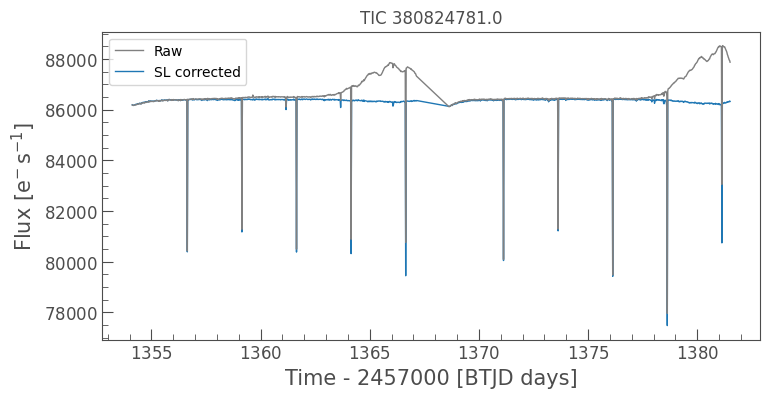

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


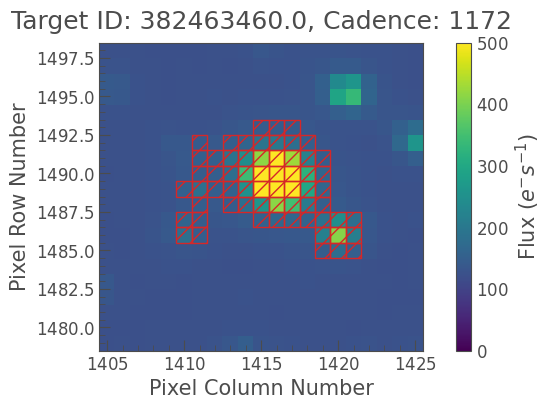

100%|██████████| 1245/1245 [00:04<00:00, 284.92it/s]


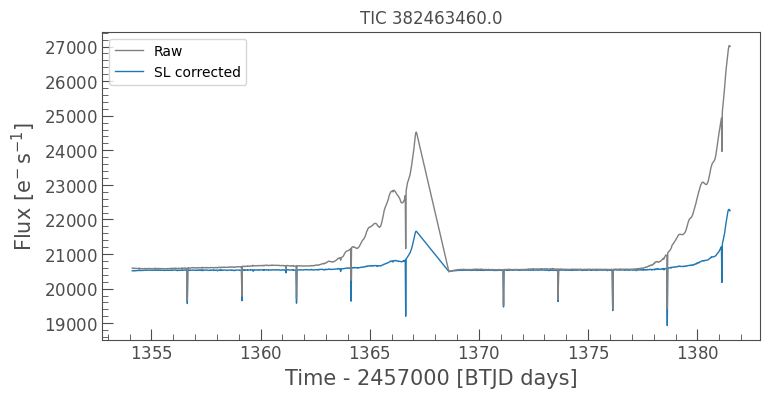

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


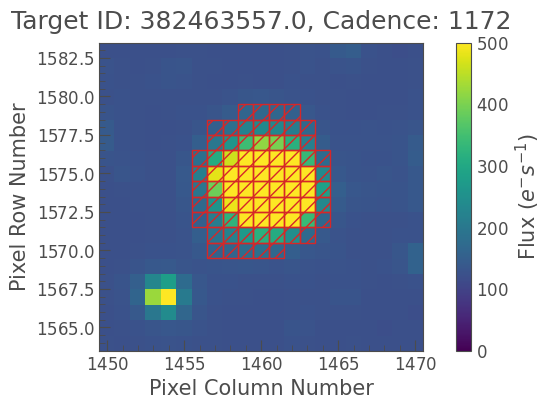

100%|██████████| 1245/1245 [00:04<00:00, 281.11it/s]


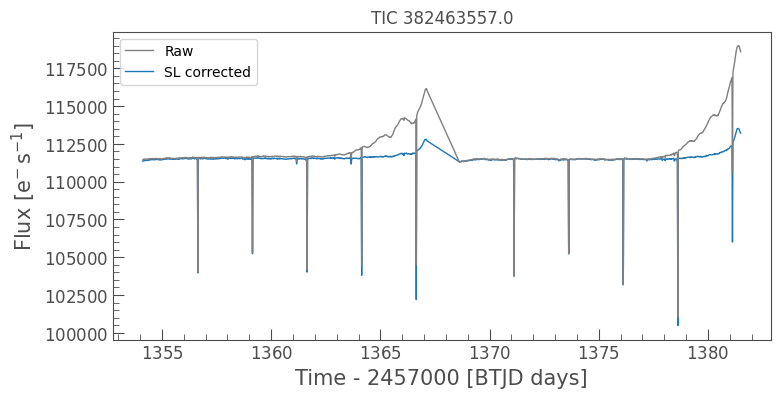

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


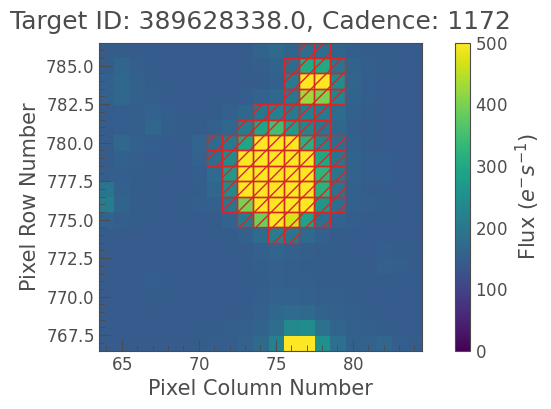

100%|██████████| 1245/1245 [00:04<00:00, 284.23it/s]


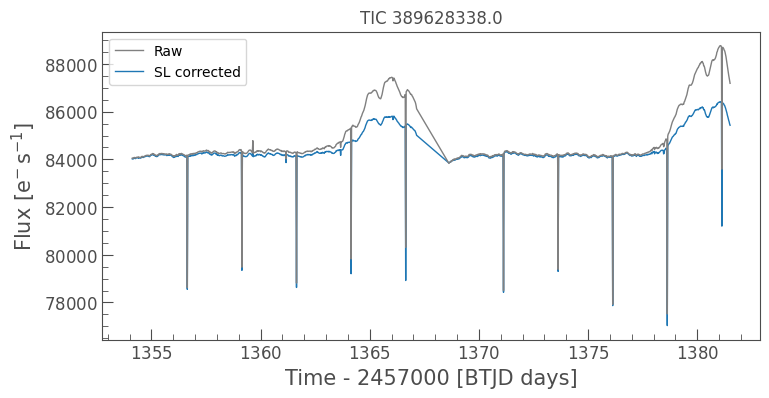

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


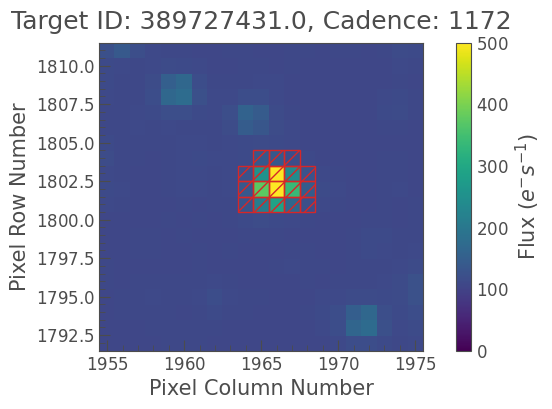

100%|██████████| 1245/1245 [00:04<00:00, 281.59it/s]


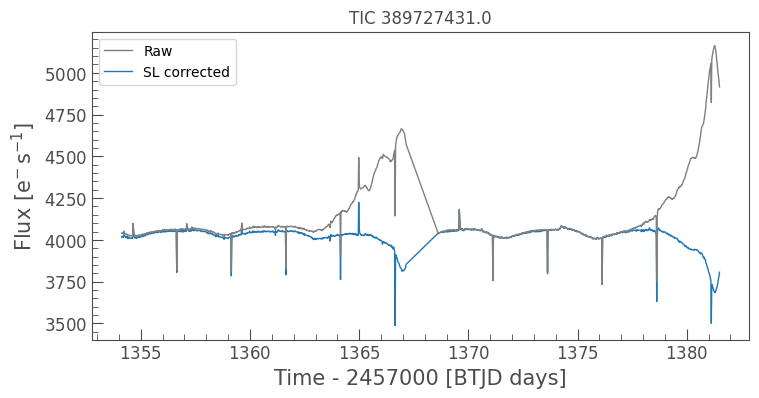

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


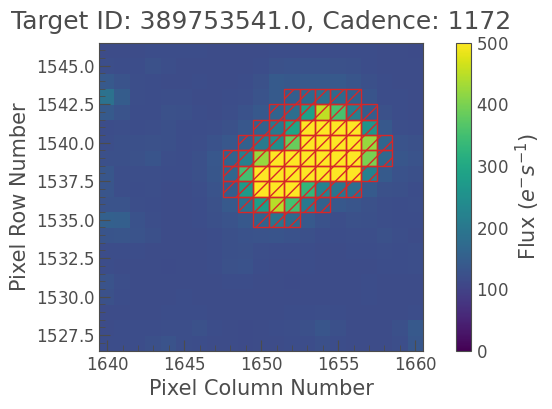

100%|██████████| 1245/1245 [00:04<00:00, 284.39it/s]


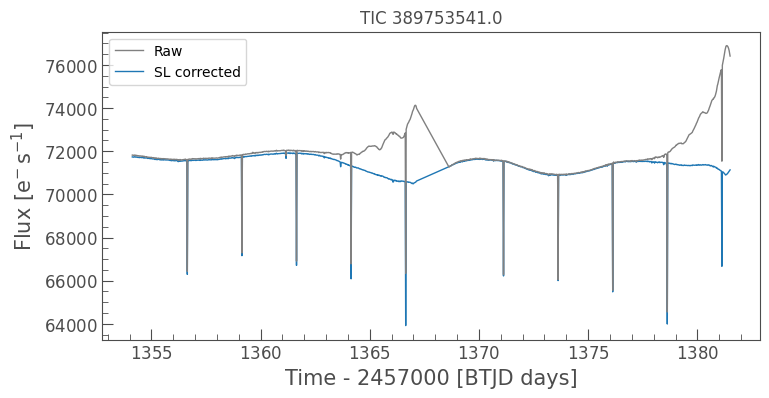

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


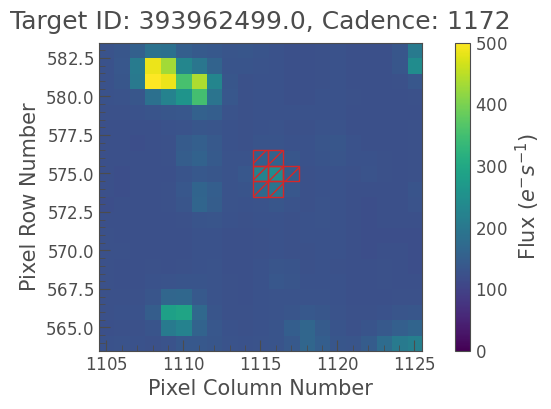

100%|██████████| 1245/1245 [00:04<00:00, 278.96it/s]


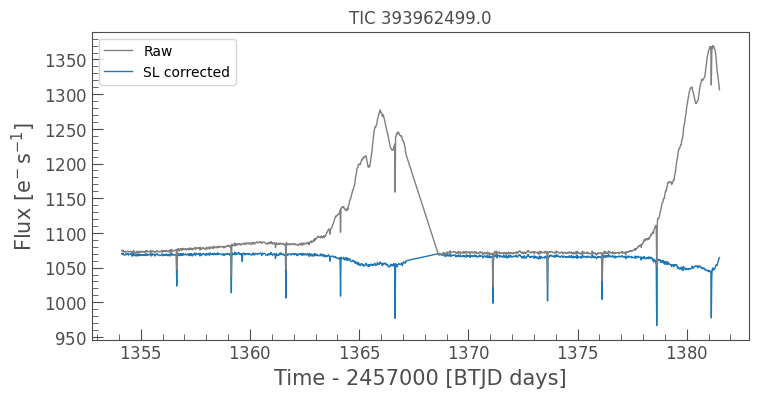

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


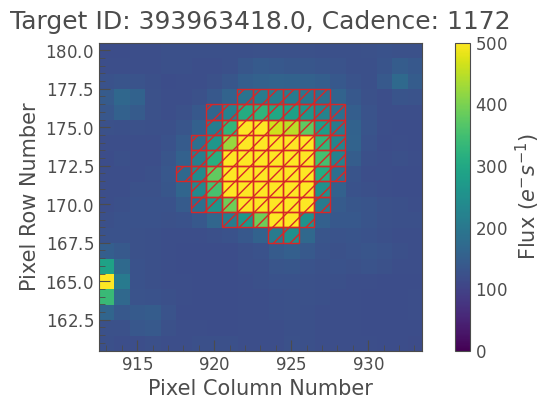

100%|██████████| 1245/1245 [00:04<00:00, 284.66it/s]


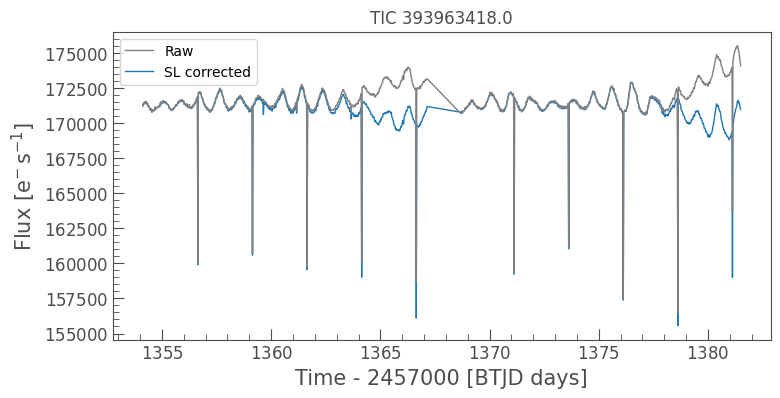

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


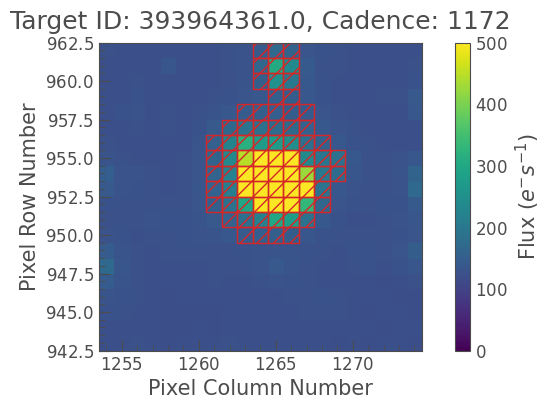

100%|██████████| 1245/1245 [00:04<00:00, 281.32it/s]


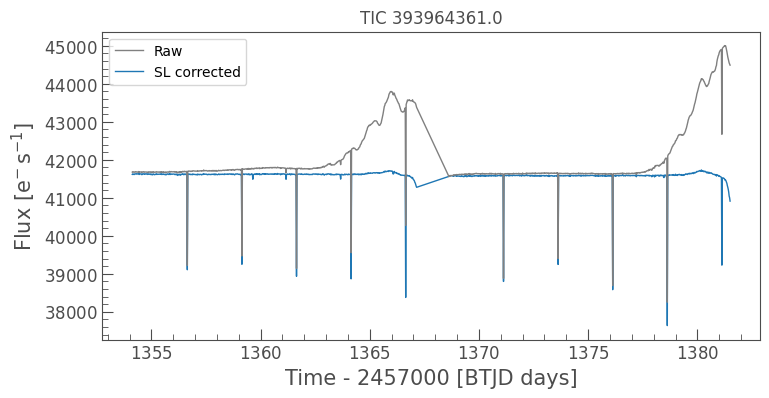

0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


INFO:lightkurve.utils:0% (0/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=0).


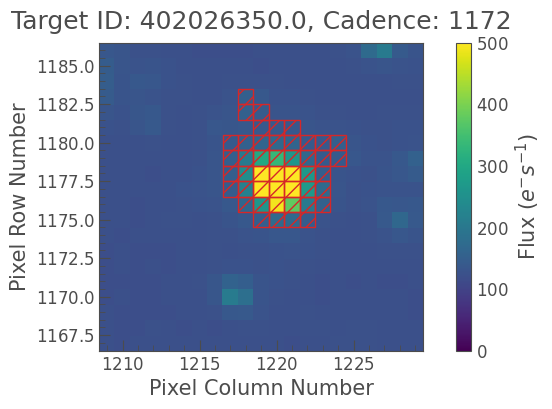

100%|██████████| 1245/1245 [00:04<00:00, 284.83it/s]


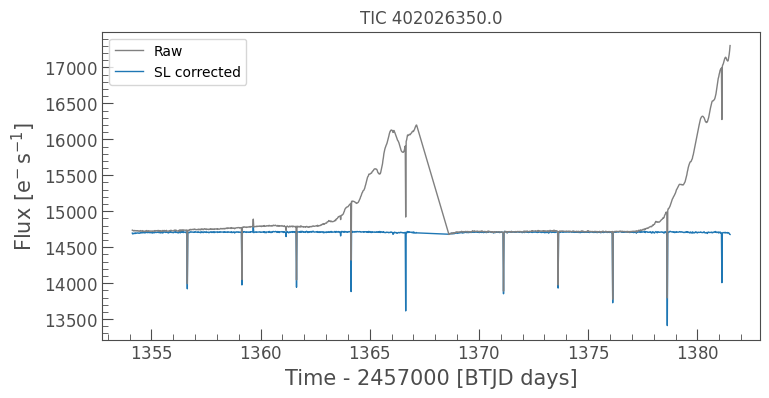

In [228]:
for k, item in tics_plot.iterrows():
    
    # coord = SkyCoord(ra=item.ra*u.deg, dec=item.dec*u.deg)
    fname = f"./data/tic_{int(item.TIC)}.0_sector{sector}_{camera}-{ccd}.fits"
    if not os.path.isfile(fname):
        fname = fname.replace(".0", "")
    
    # tcube.get_tpf(coord).writeto(fname, overwrite=True)
    tpf = lk.read(fname, quality_bitmask="none")
    tpf.targetid = item.TIC
    
    apmask = tpf.create_threshold_mask(threshold=5)
    tpf.plot(frame=1172, aperture_mask=apmask, mask_color="tab:red", vmin=0, vmax=500);
    plt.show()
    
    scatlight = []
    
    step = binsize
    row = np.arange(rmin, rmax, step)
    col = np.arange(cmin, cmax, step)
    eval_row = np.arange(tpf.row, tpf.row + tpf.shape[1])
    eval_col = np.arange(tpf.column, tpf.column + tpf.shape[2])
    
    for tdx in tqdm(range(cube_sl.shape[0])):
        interp2d = RectBivariateSpline(col, row, cube_sl_lin[tdx] if fillnan else cube_sl[tdx])
        eval_sl = interp2d(eval_col, eval_row)
        scatlight.append(eval_sl.T)
        
    scatlight = np.array(scatlight)
    tpf.flux_corr = tpf.flux - scatlight * tpf.flux.unit
    
    lc = tpf.extract_aperture_photometry(aperture_mask=apmask)
    lc_corr = np.nansum(tpf.flux_corr[:, apmask], axis=1)
    
    ax = lc.plot(label="Raw", lw=1, c="gray")
    ax.plot(lc.time.value, lc_corr, label="SL corrected", zorder=-5000, lw=1, c="tab:blue")
    ax.set_title(f"TIC {item.TIC}")
    plt.legend()
    plt.show()

    # break